# Description: Using the QLattice to solve the Carbon price projections

In [46]:
import numpy as np
import pandas as pd
import feyn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
from IPython.display import Image, display  
import matplotlib.pyplot as plt
%matplotlib inline

## The training model is constructed using the decomposition results of Guangzhou dataset and the prediction results of IMF and RES are output

In [47]:
# Data Load
file_path = '...TGSINFO-VMD-GZ.csv'
data = pd.read_csv(file_path)
print(data.head())

        IMF1      IMF2      IMF3      IMF4      IMF5      IMF6      IMF7  \
0  13.837119 -2.489486 -0.646670  0.409173  0.172960 -0.110624  0.318439   
1  13.834802 -2.487430 -0.629177  0.389222  0.082743 -0.016921 -0.013208   
2  13.832054 -2.481336 -0.591882  0.342321 -0.045562  0.098216 -0.324656   
3  13.830723 -2.469263 -0.533121  0.254361 -0.142307  0.139613 -0.292376   
4  13.826522 -2.455520 -0.458993  0.104596 -0.166336  0.058372  0.034494   

       IMF8      IMF9     IMF10     IMF11     IMF12     IMF13     IMF14  \
0 -0.065352  0.127437  0.178473  0.092389 -0.020708 -0.017125 -0.022317   
1 -0.002928 -0.126114 -0.229654 -0.158757  0.064411  0.045554  0.067209   
2  0.090648 -0.119918 -0.111113  0.027392 -0.091016 -0.050380 -0.105420   
3  0.096753  0.124840  0.270415  0.138627  0.070466  0.025404  0.130724   
4 -0.054806  0.104005  0.023089 -0.139680  0.002466  0.015973 -0.140955   

      IMF15     IMFRS  
0 -0.007925  0.124217  
1  0.025821  0.034429  
2 -0.042630 -0.12671

In [48]:
sns.set_style("darkgrid", {'axes.grid' : True})
loop_outputs = []
saved_images = []
sum_of_Test = np.array([])
Test_total_sum_of_predictions = np.array([])
sum_of_Valture = np.array([])
Val_total_sum_of_predictions = np.array([])

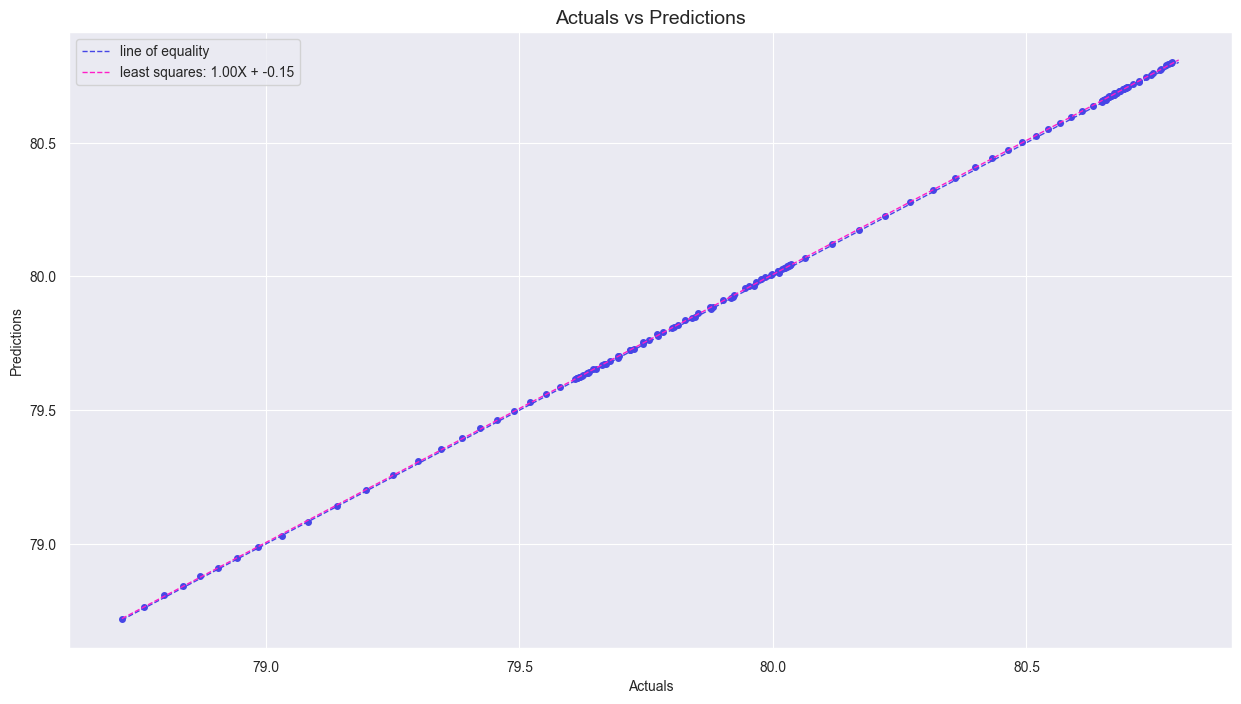

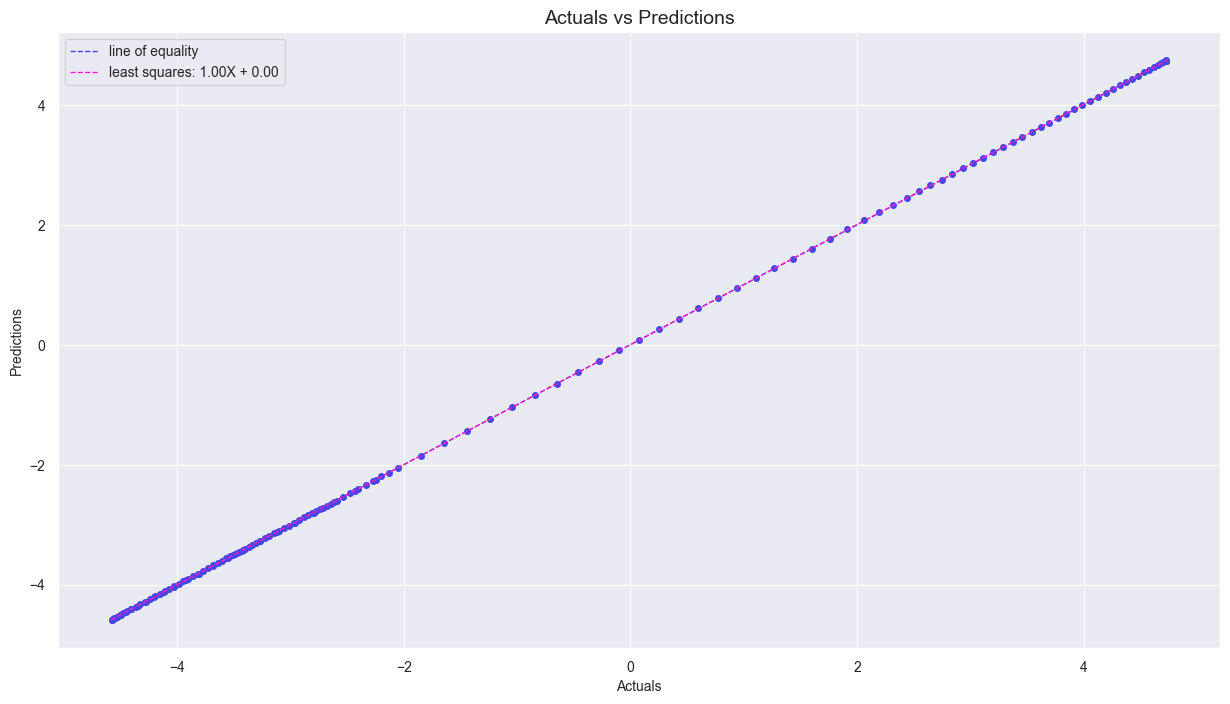

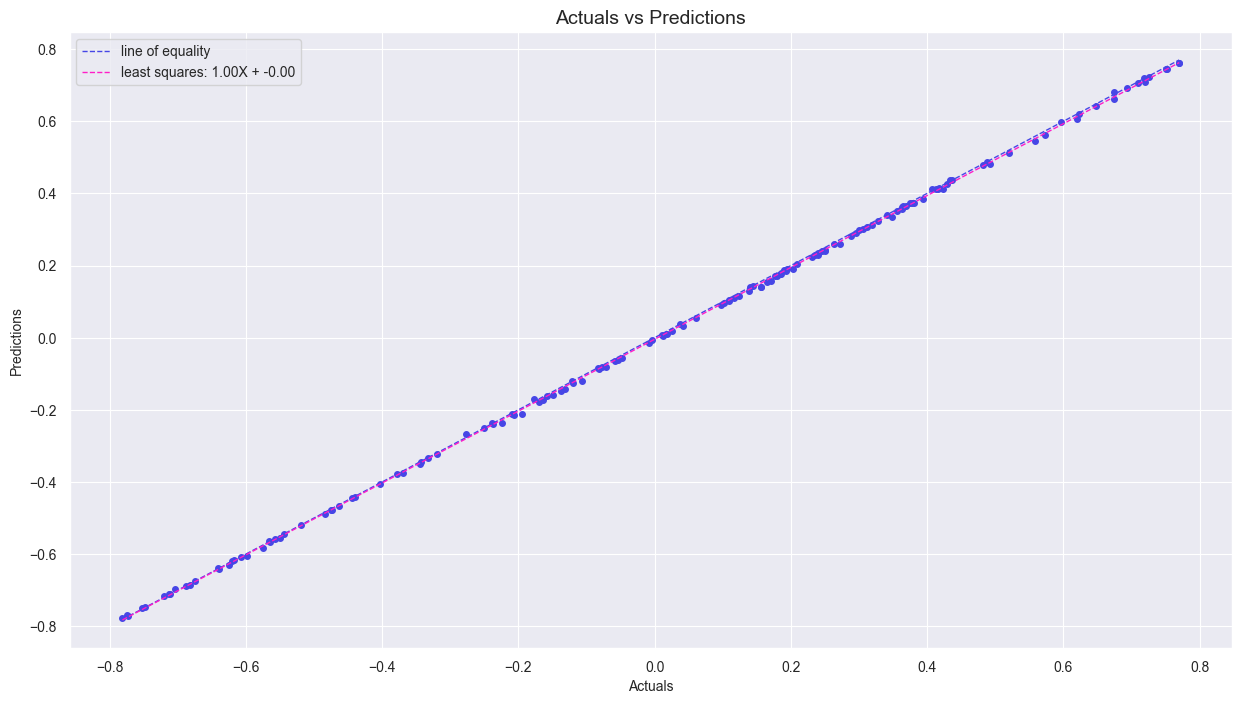

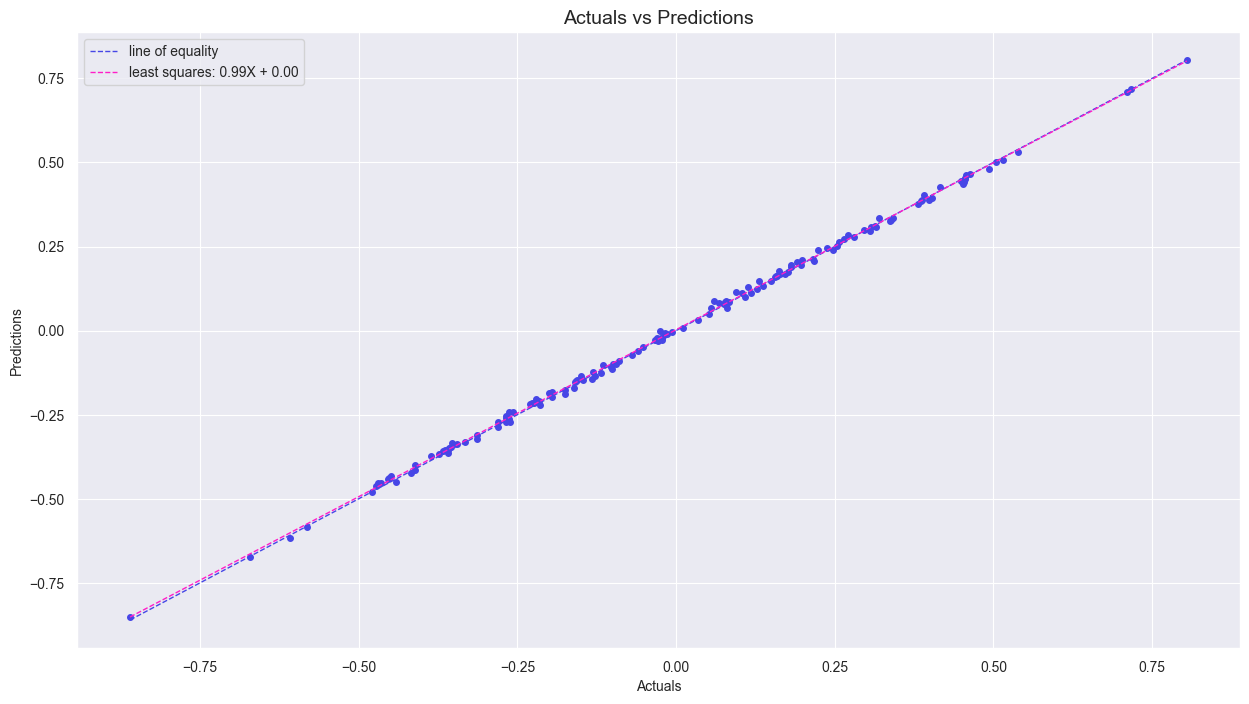

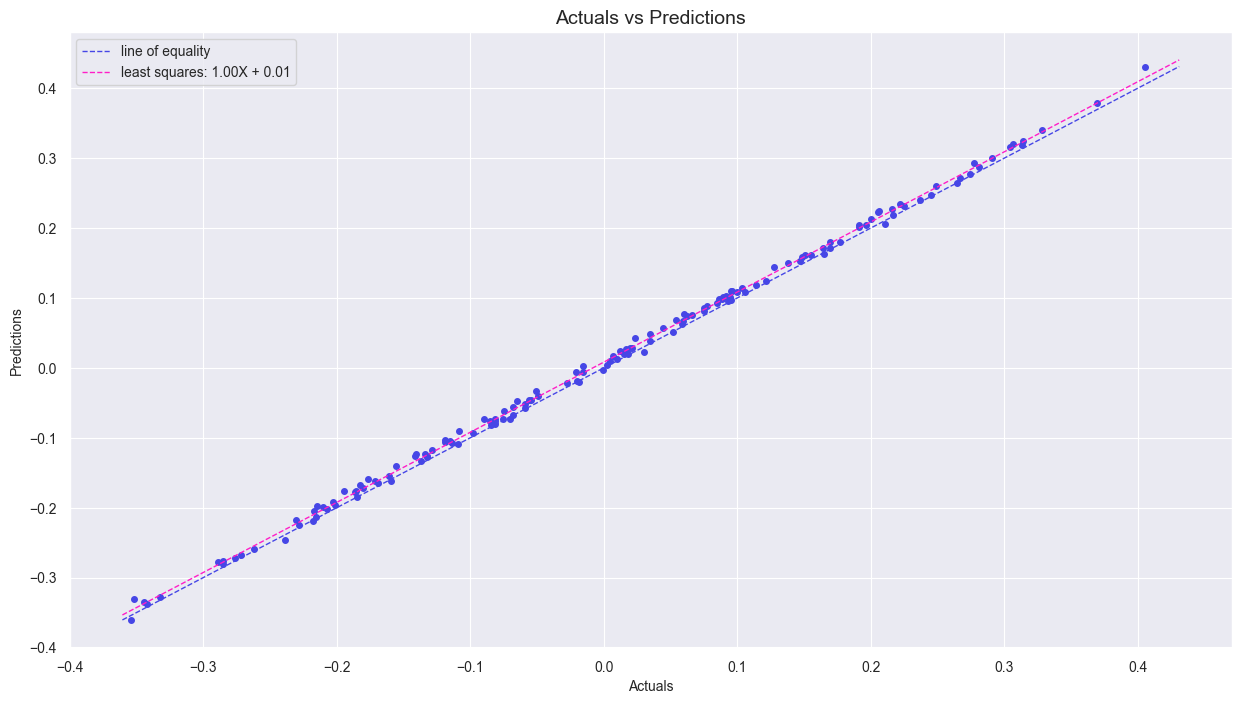

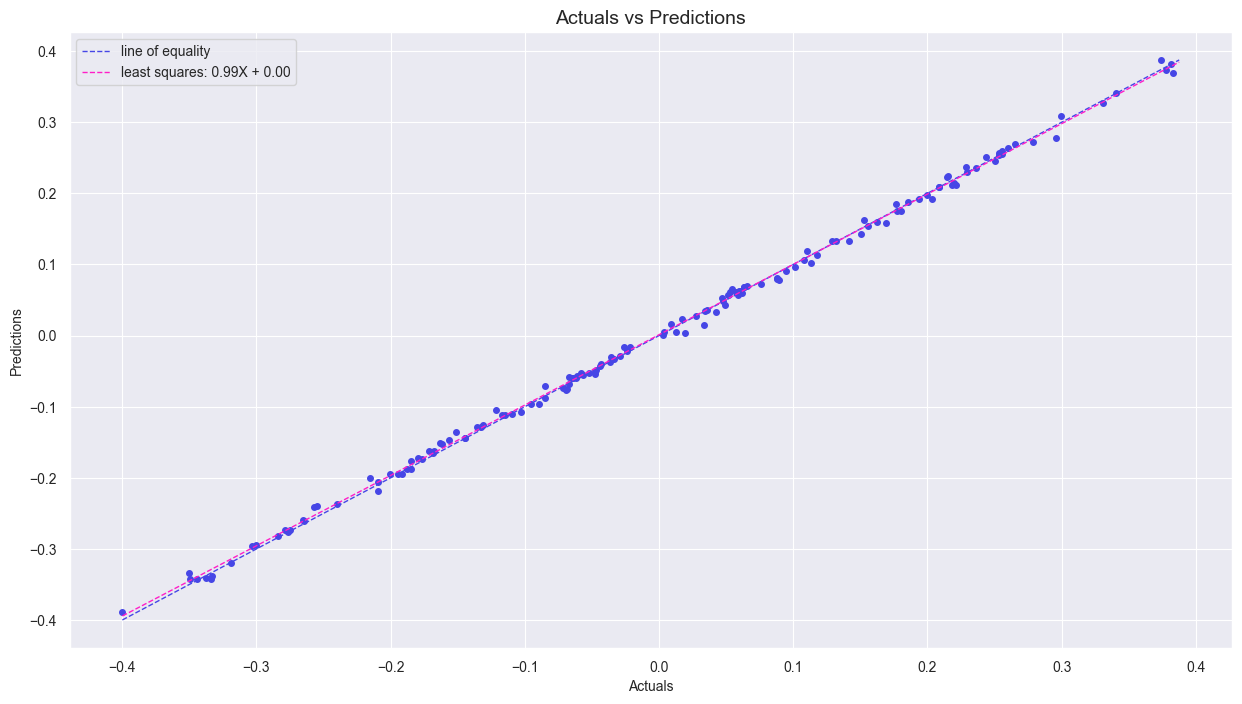

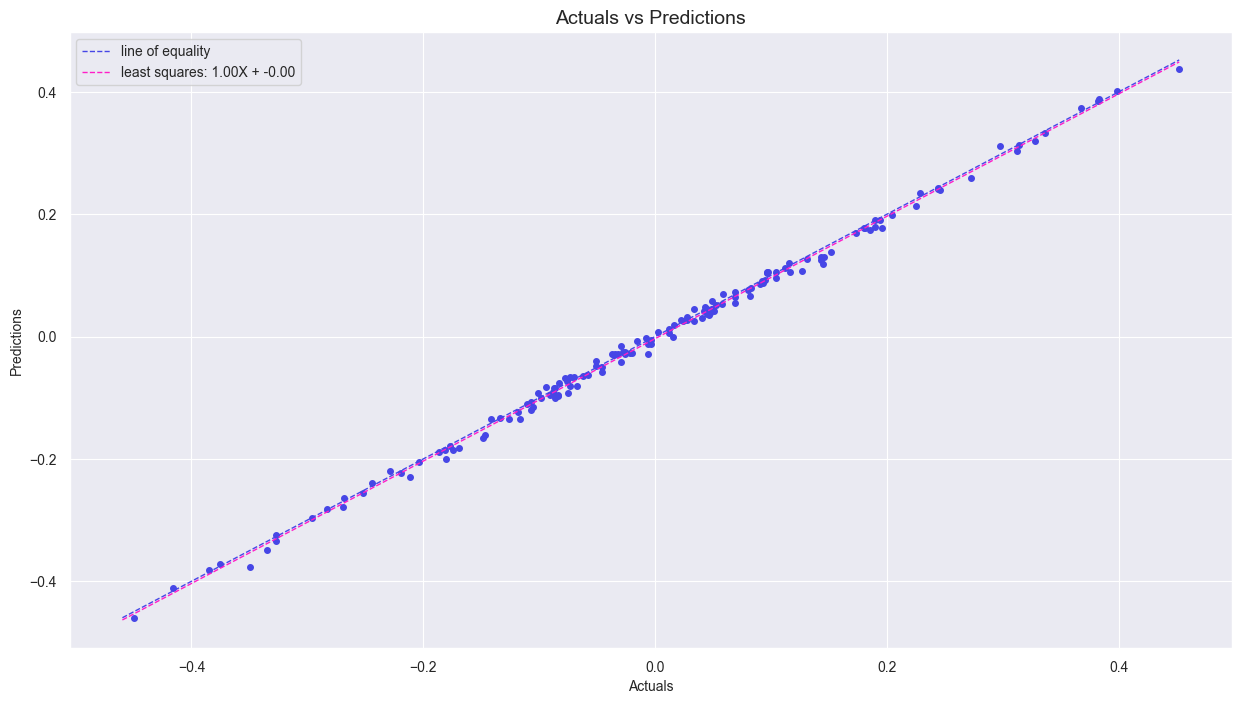

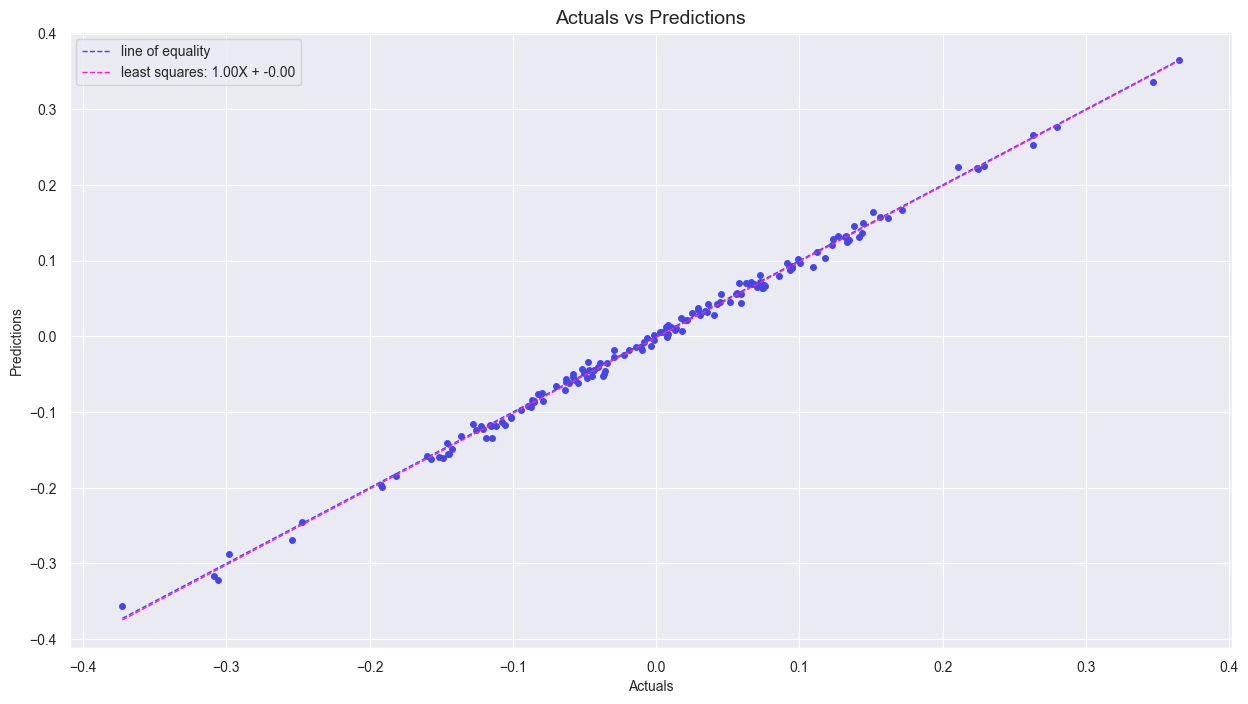

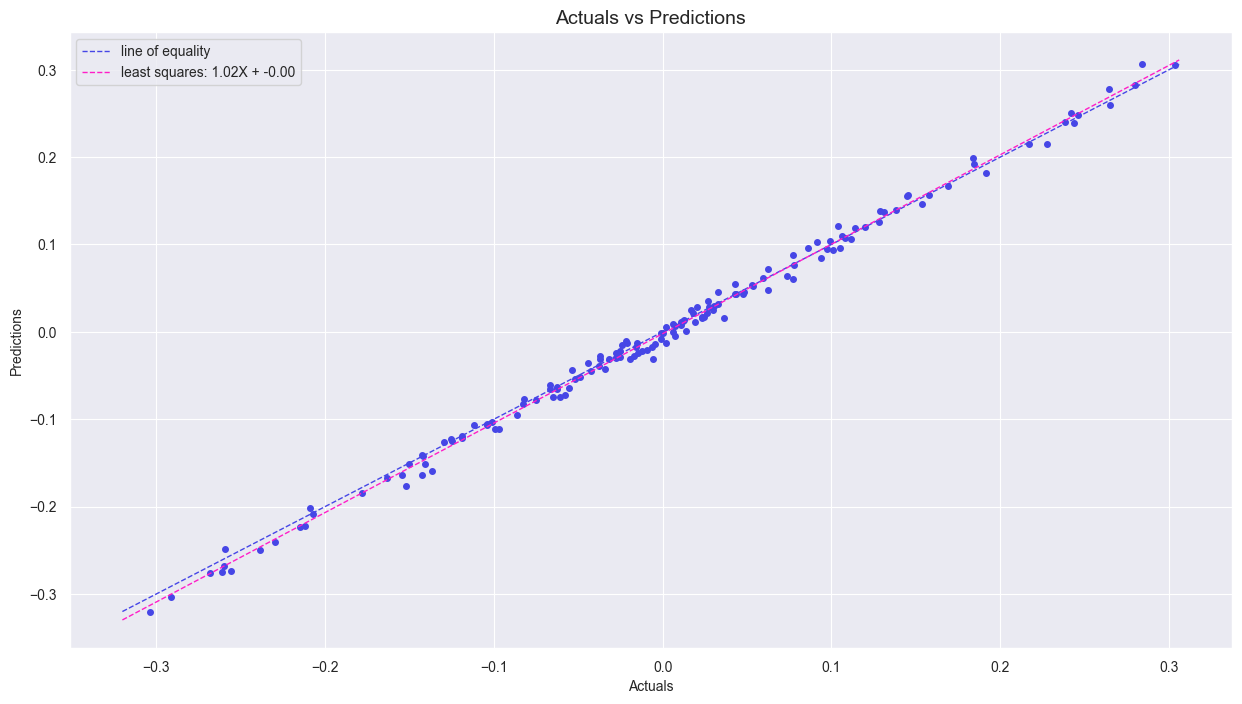

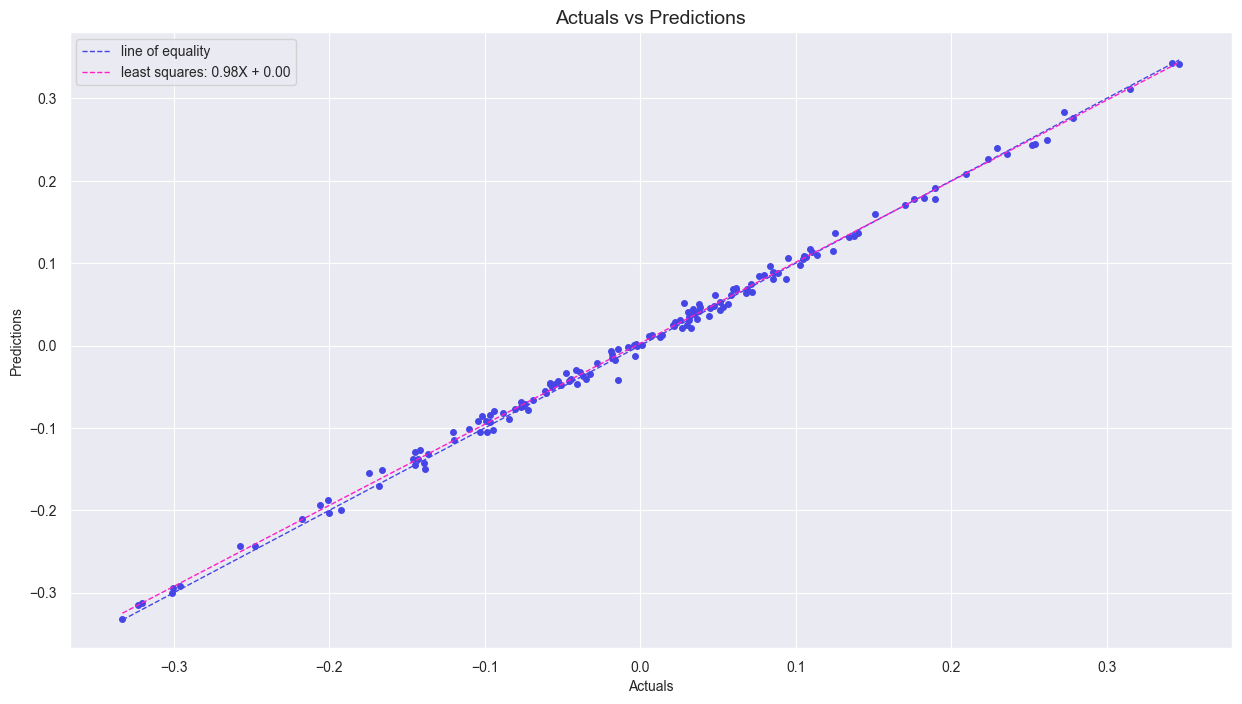

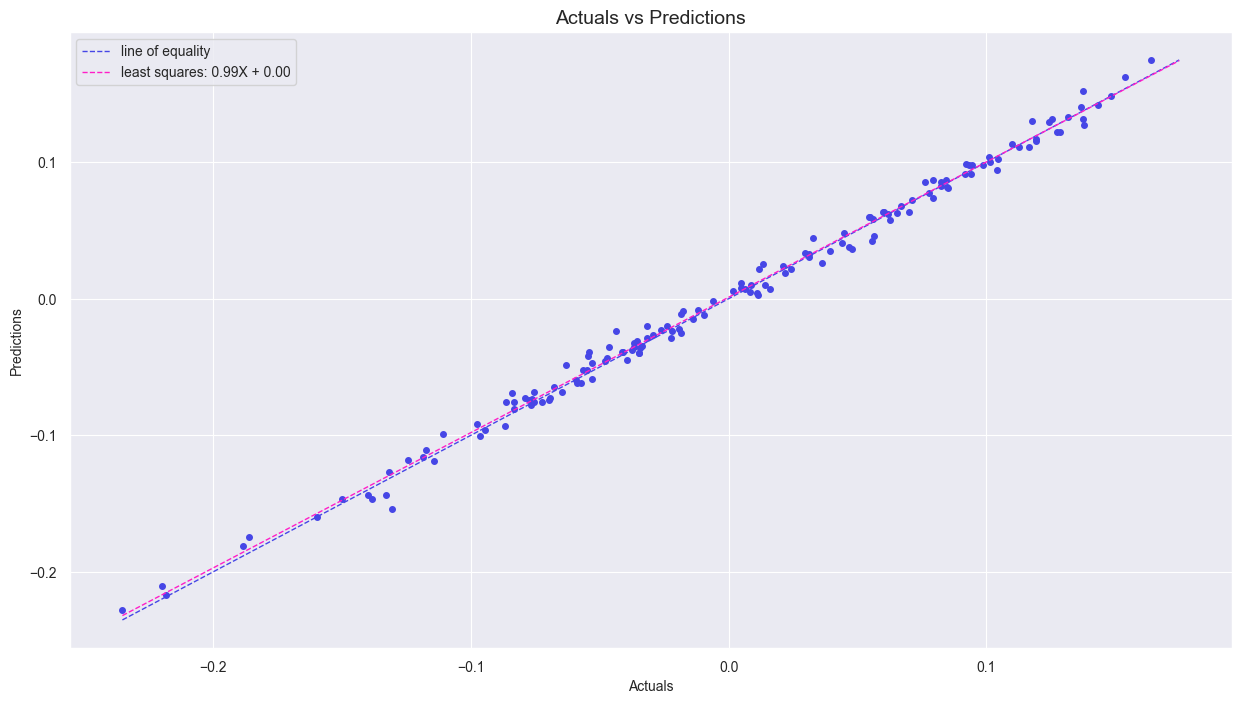

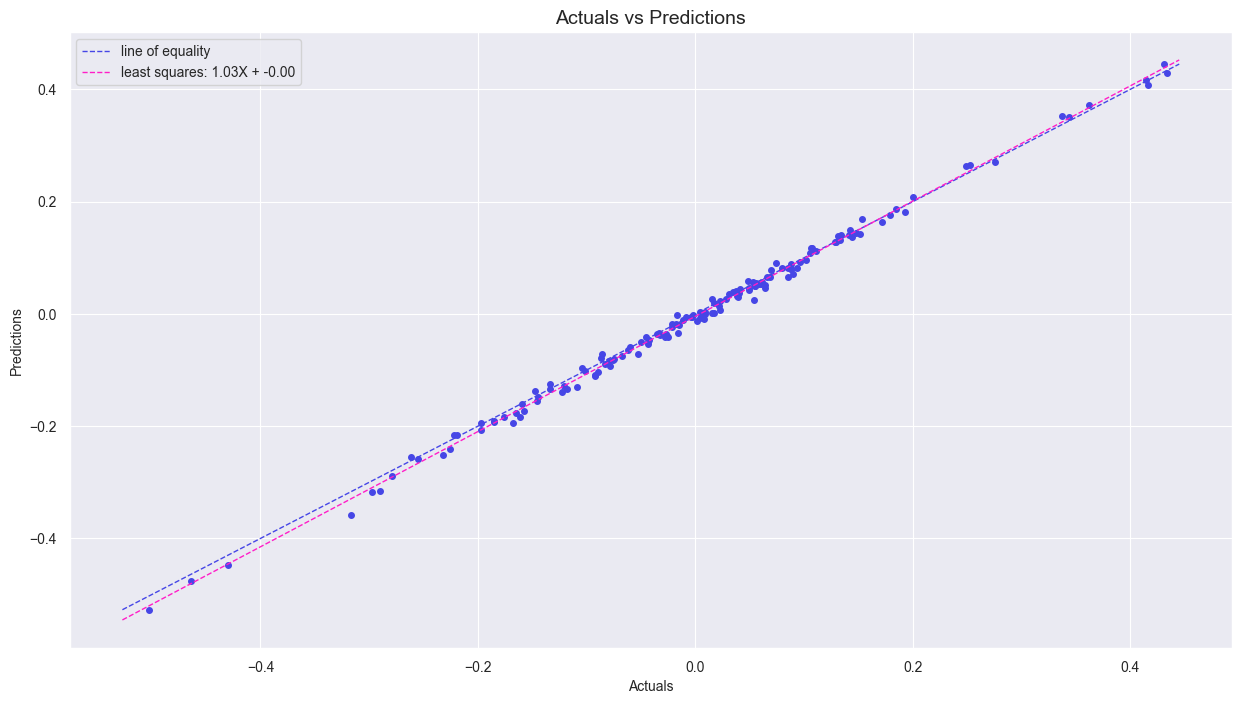

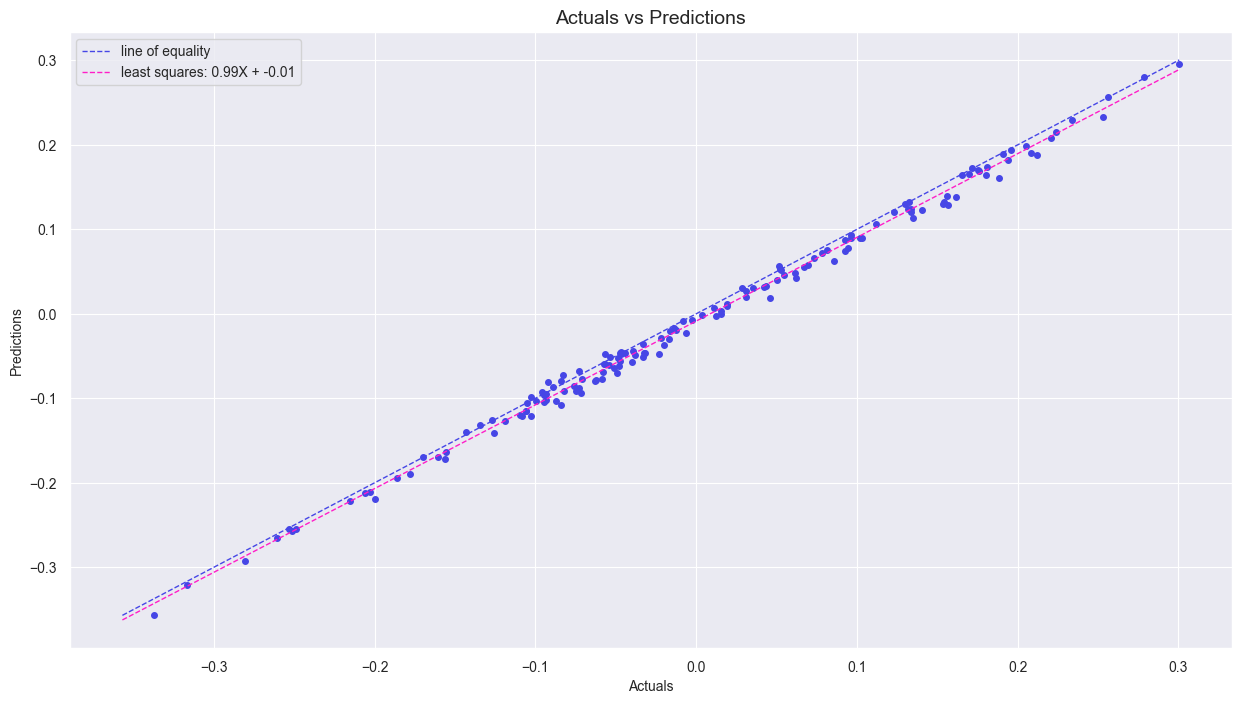

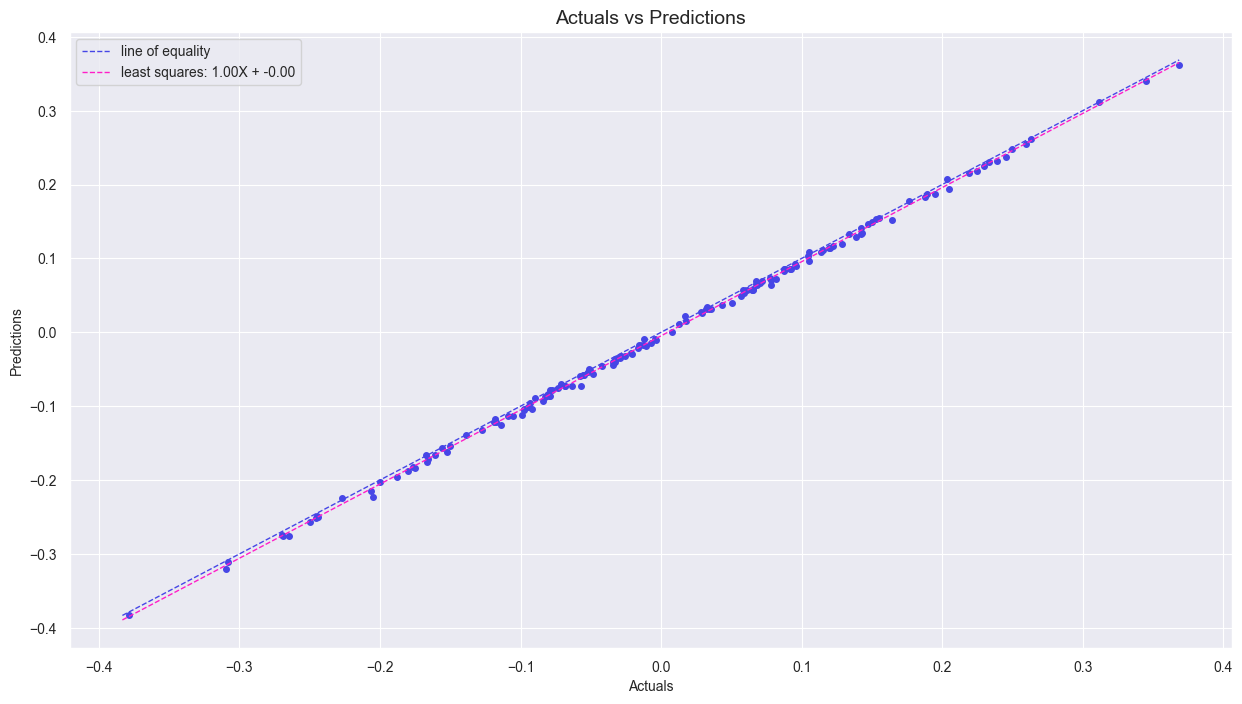

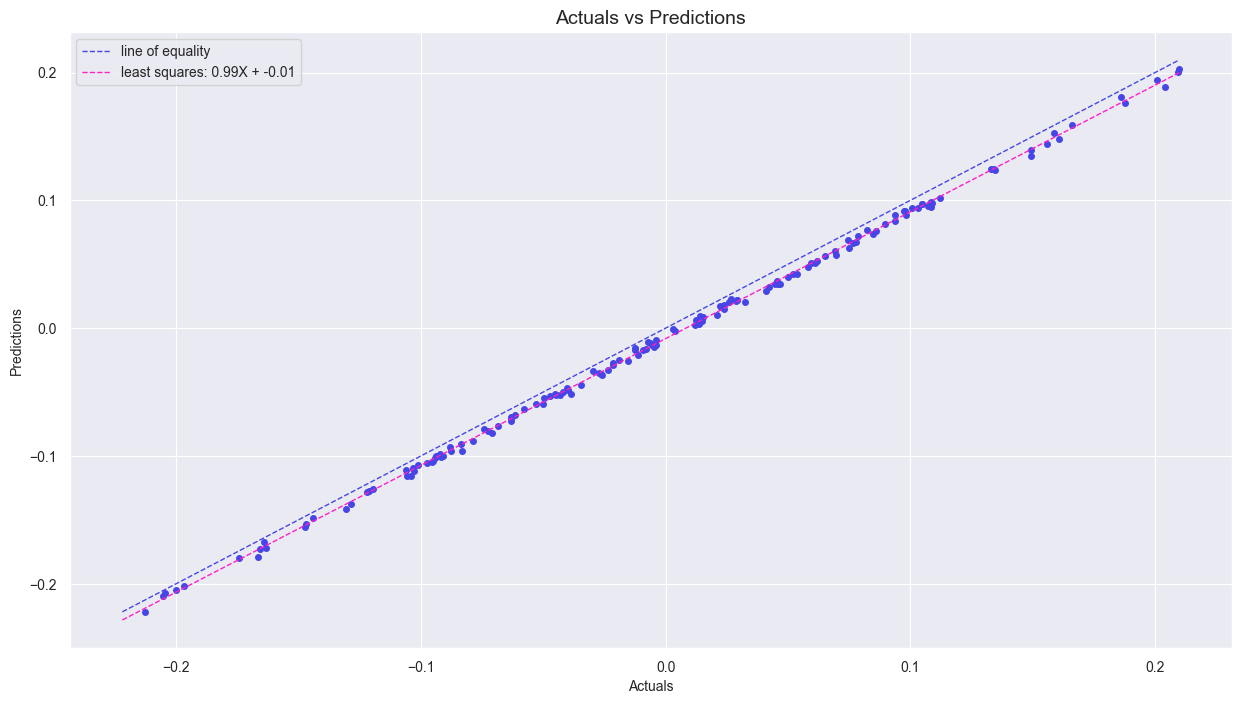

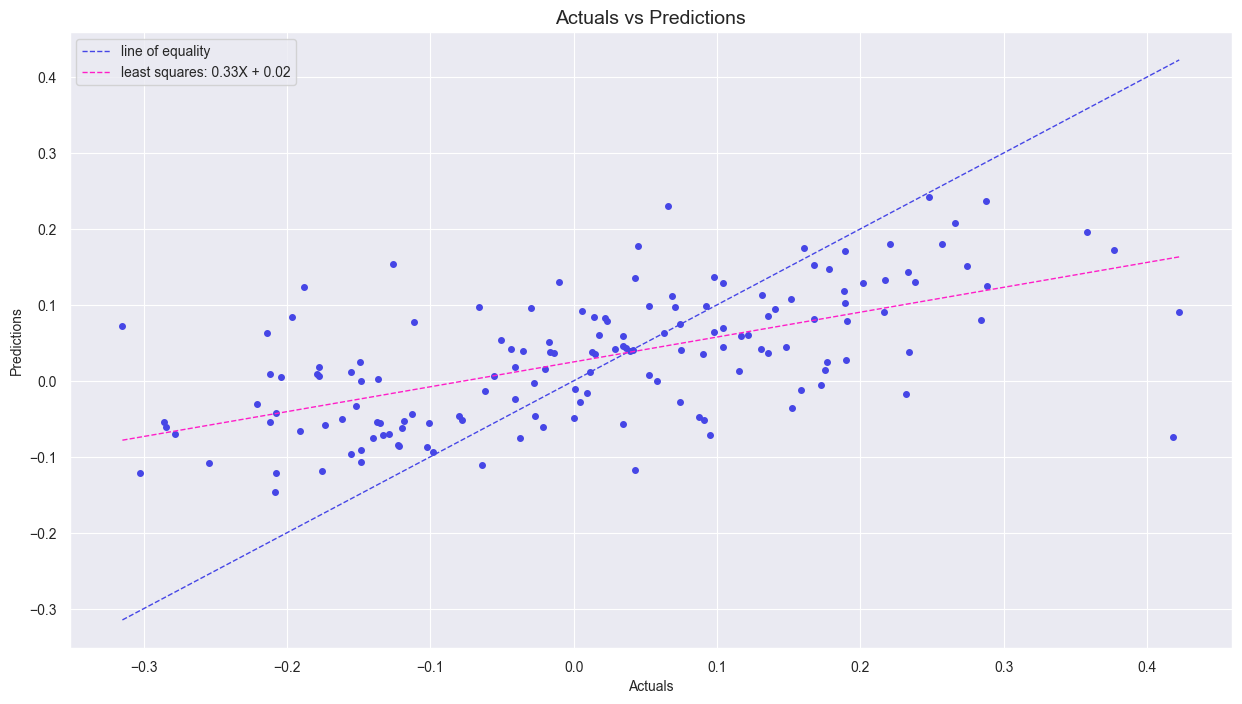

In [49]:
number_of_lags = 5  #The number of hysteresis features, set here to the last 5 days to predict the next 1 day, can be modified as needed

# Traversing all IMF components and Res
for index, column in enumerate(data.columns):
    column_output = f"Deal: {column}\n"
    
    split_data = pd.DataFrame()
    column_data = data[column]
    
    split_data['target'] = column_data.values
    
    # Create a lagging feature
    for lag in range(1, number_of_lags + 1):
        split_data[f'fac{lag}'] = column_data.shift(lag)
    split_data.dropna(inplace=True)
    
    split_data.reset_index(drop=True, inplace=True)
   
    column_output += f"{column} split:\n{split_data.head()}\n"
    
    columns_with_na = split_data.columns[split_data.isna().any().values].to_list()
    
    # Divide the training data and test set
    total_rows = split_data.shape[0]
    train_ratio = 0.9
    test_ratio = 0.1
    train_rows = int(total_rows * train_ratio)
    test_rows = total_rows - train_rows
    train = split_data.iloc[:train_rows, :]
    test = split_data.iloc[train_rows:, :]    
    column_output += f"{column} Training data:\n{train}\n"
    column_output += f"{column} Test set:\n{test}\n"
    
    if sum_of_Test.size == 0:
        sum_of_Test = test['target']
    else:
        sum_of_Test += test['target']
        
    output = 'target'

    # The training data are further divided into training set and validation set
    train_t, train_v = train_test_split(train, test_size=0.4, random_state=42)
    
    column_output += f"{column} Training set:\n{train_t}\n"
    column_output += f"{column} Validation set:\n{train_v}\n"
    
    if sum_of_Valture.size == 0:
        sum_of_Valture = train_v['target']
    else:
        sum_of_Valture += train_v['target']
    print(sum_of_Valture)

    # Link to QLattice
    ql = feyn.connect_qlattice()
    
    # Model training
    models = ql.auto_run(train_t, output, kind='regression')
    
    best_model = models[0]
    
    # Use validation sets to make predictions
    train_v_pre=best_model.predict(train_v)
    train_v.iloc[:,0].shape

    val_output = pd.DataFrame({'Actual': train_v['target'], 'Predicted': train_v_pre})
    val_output.to_csv(f'{column}_val_predictions.csv', index=False)
    column_output += f"{column} validation set prediction results have been saved as CSV file\n"

    if Val_total_sum_of_predictions.size == 0:
        Val_total_sum_of_predictions = train_v_pre
    else:
        Val_total_sum_of_predictions += train_v_pre
    
    
    plt.figure(figsize=(15, 8))
    ind = [i for i in range(len(train_v_pre))]
    plt.plot(ind, train_v.iloc[:,0], label='Real Value', color='navy', linestyle='-')
    plt.plot(ind, train_v_pre, label='Predicted Value', color='orange', linestyle='--')
    plt.title(f"{column} - Validation Set Predictions")
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend(loc='upper left')
    validation_plot_path = f"validation_{column}.png"
    plt.savefig(validation_plot_path)  
    saved_images.append(validation_plot_path)  
    plt.close()  

    
    # Use the test set for prediction
    test_pre=best_model.predict(test)

    test_output = pd.DataFrame({'Actual': test['target'], 'Predicted': test_pre})
    test_output.to_csv(f'{column}_test_predictions.csv', index=False)
    column_output += f"{column} test set prediction results have been saved as a CSV file\n"

    if Test_total_sum_of_predictions.size == 0:
        Test_total_sum_of_predictions = test_pre
    else:
        Test_total_sum_of_predictions += test_pre    

    plt.figure(figsize=(15, 8))
    ind = [i for i in range(len(test_pre))]
    plt.plot(ind, test.iloc[:,0], label='Real Value', color='navy', linestyle='-')
    plt.plot(ind, test_pre, label='Predicted Value', color='orange', linestyle='--')
    plt.title(f"{column} - Test Set Predictions")
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend(loc='upper left')
    test_plot_path = f"test_{column}.png"
    plt.savefig(test_plot_path)  
    saved_images.append(test_plot_path)  
    plt.close()  

    
    # Model evaluation 
    best_model.plot(train_v, test)
    sympy_model = best_model.sympify(signif=3)
    
    column_output += f"{column} mathematical expression:\n{sympy_model.as_expr()}\n"
    
    loop_outputs.append(column_output)

    y_true = test['target']
    y_pred=best_model.predict(test)

    from feyn.plots import plot_regression
    plot_regression(y_true, y_pred)

# Save Point prediction results
pd.DataFrame({'Test Predictions': Test_total_sum_of_predictions}).to_csv('Test_total_sum_of_predictions.csv', index=False)
pd.DataFrame({'Val Predictions': Val_total_sum_of_predictions}).to_csv('Val_total_sum_of_predictions.csv', index=False)
pd.DataFrame({'Val ture': sum_of_Valture}).to_csv('sum_of_Valture.csv', index=False)
pd.DataFrame({'Test ture':sum_of_Test}).to_csv('sum_of_Test.csv', index=False)

In [50]:
for output in loop_outputs:
    print(output)

Deal: IMF1
IMF1 split:
      target       fac1       fac2       fac3       fac4       fac5
0  13.822145  13.826522  13.830723  13.832054  13.834802  13.837119
1  13.822460  13.822145  13.826522  13.830723  13.832054  13.834802
2  13.826148  13.822460  13.822145  13.826522  13.830723  13.832054
3  13.835461  13.826148  13.822460  13.822145  13.826522  13.830723
4  13.851420  13.835461  13.826148  13.822460  13.822145  13.826522
IMF1 Training data:
         target       fac1       fac2       fac3       fac4       fac5
0     13.822145  13.826522  13.830723  13.832054  13.834802  13.837119
1     13.822460  13.822145  13.826522  13.830723  13.832054  13.834802
2     13.826148  13.822460  13.822145  13.826522  13.830723  13.832054
3     13.835461  13.826148  13.822460  13.822145  13.826522  13.830723
4     13.851420  13.835461  13.826148  13.822460  13.822145  13.826522
...         ...        ...        ...        ...        ...        ...
1360  78.496045  78.447945  78.397928  78.346609  78

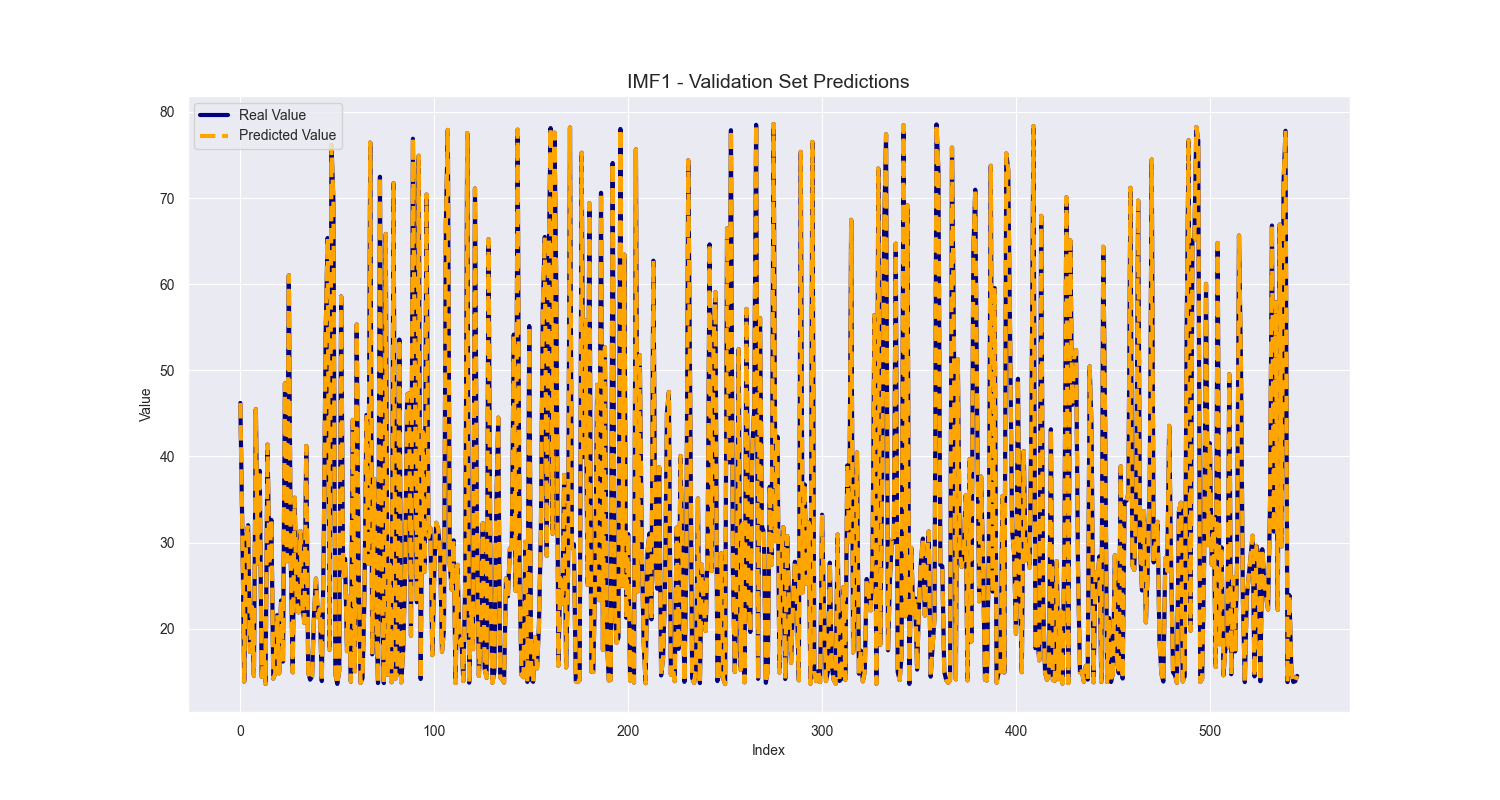

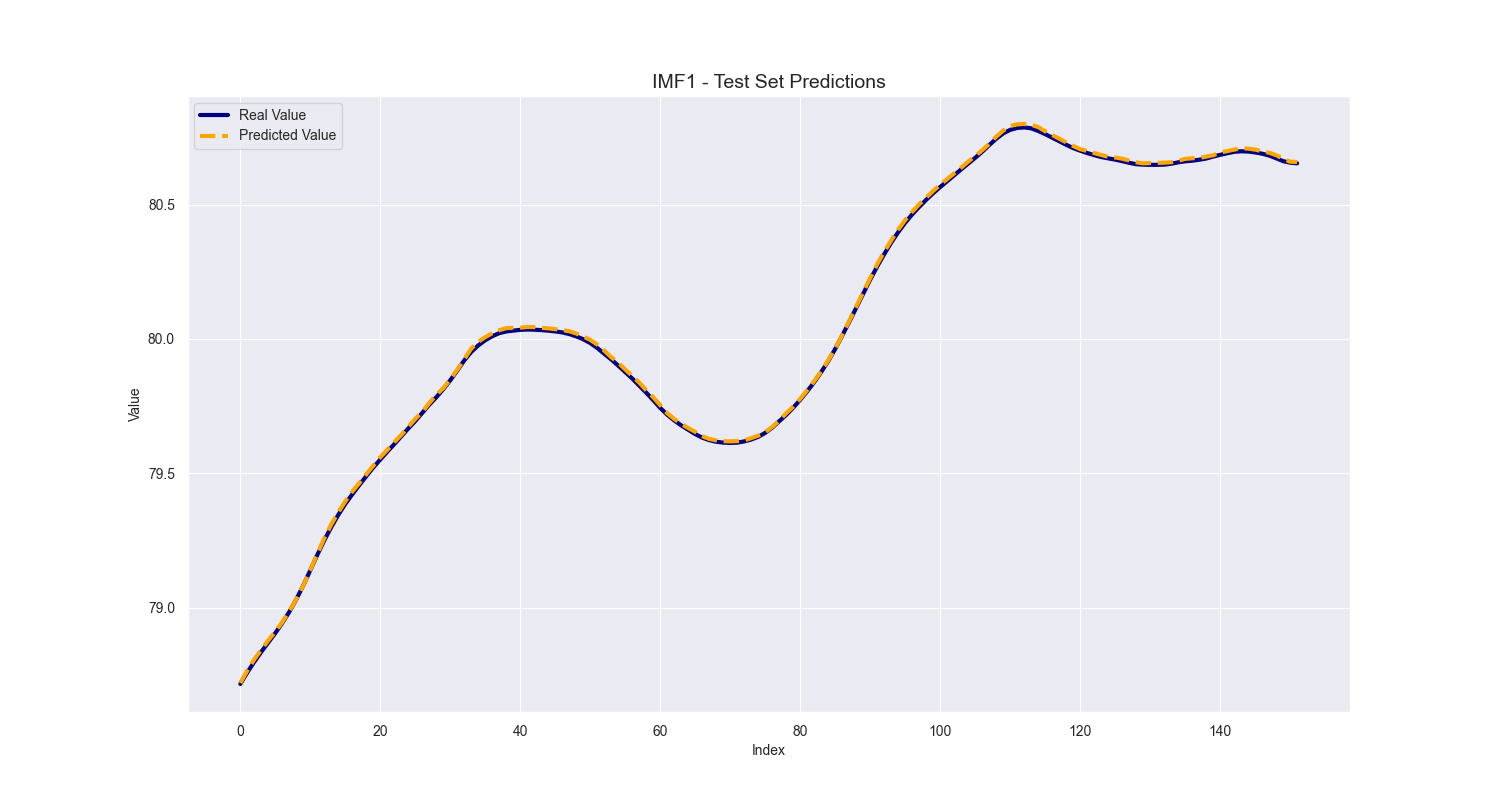

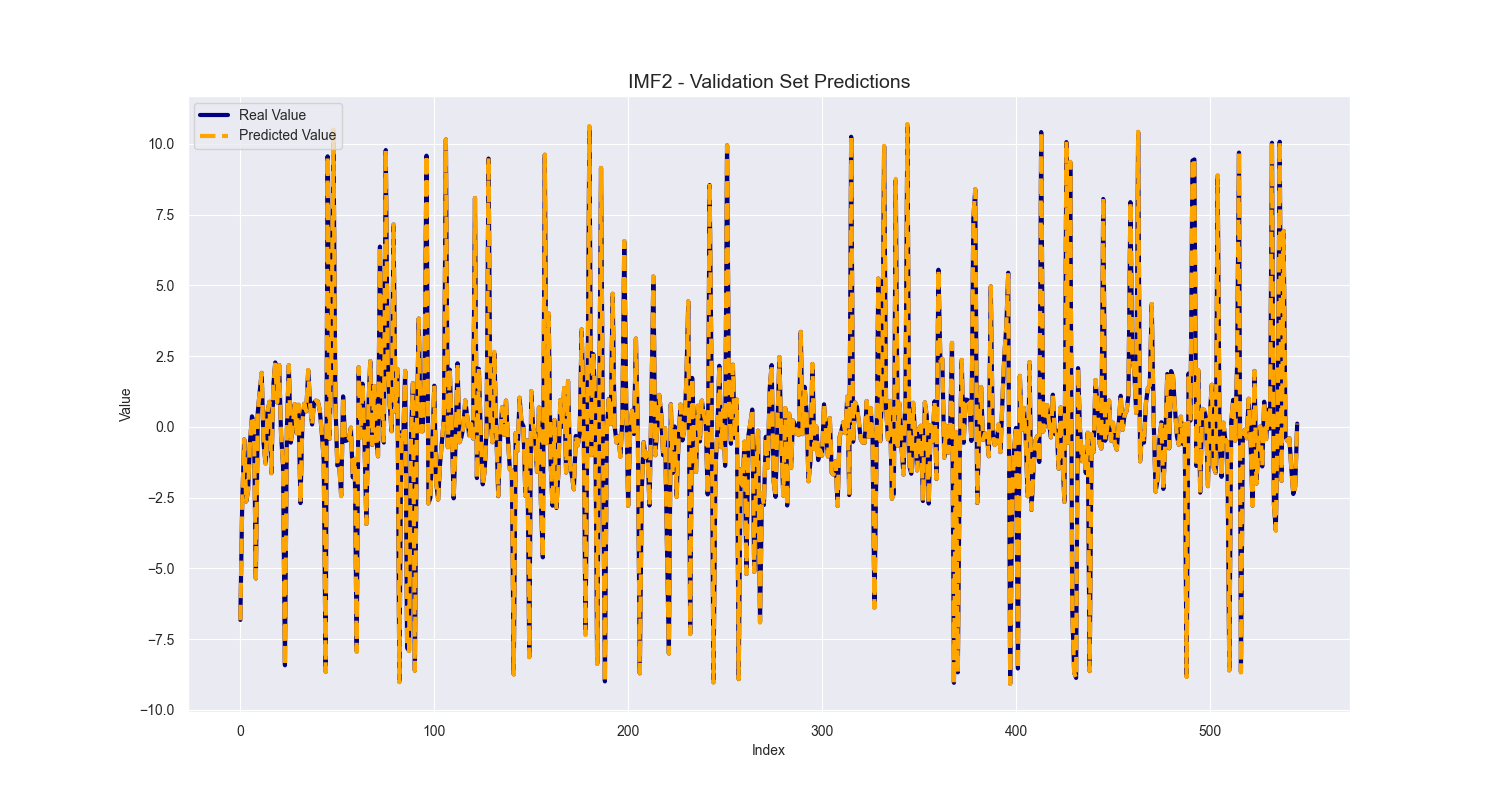

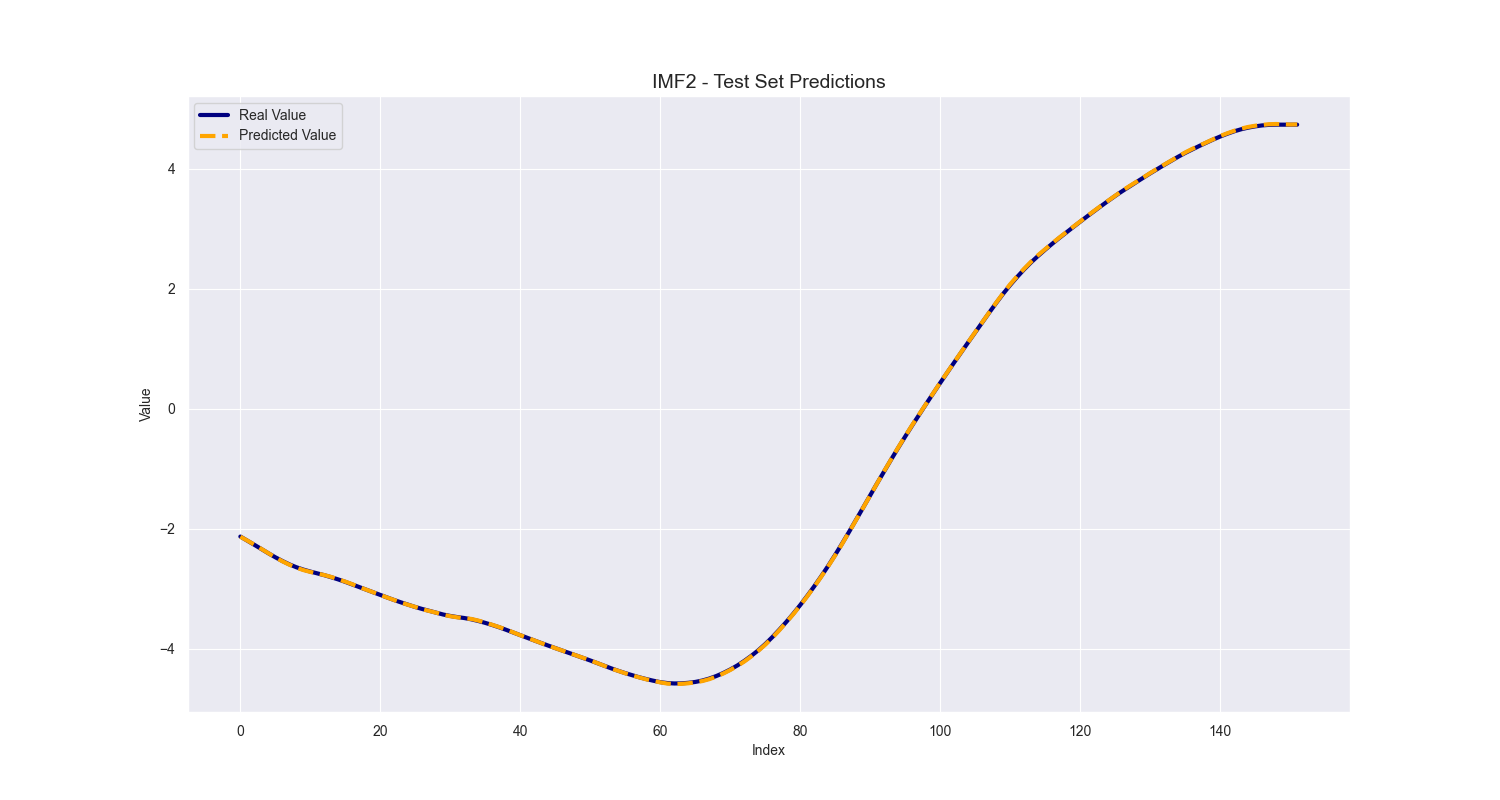

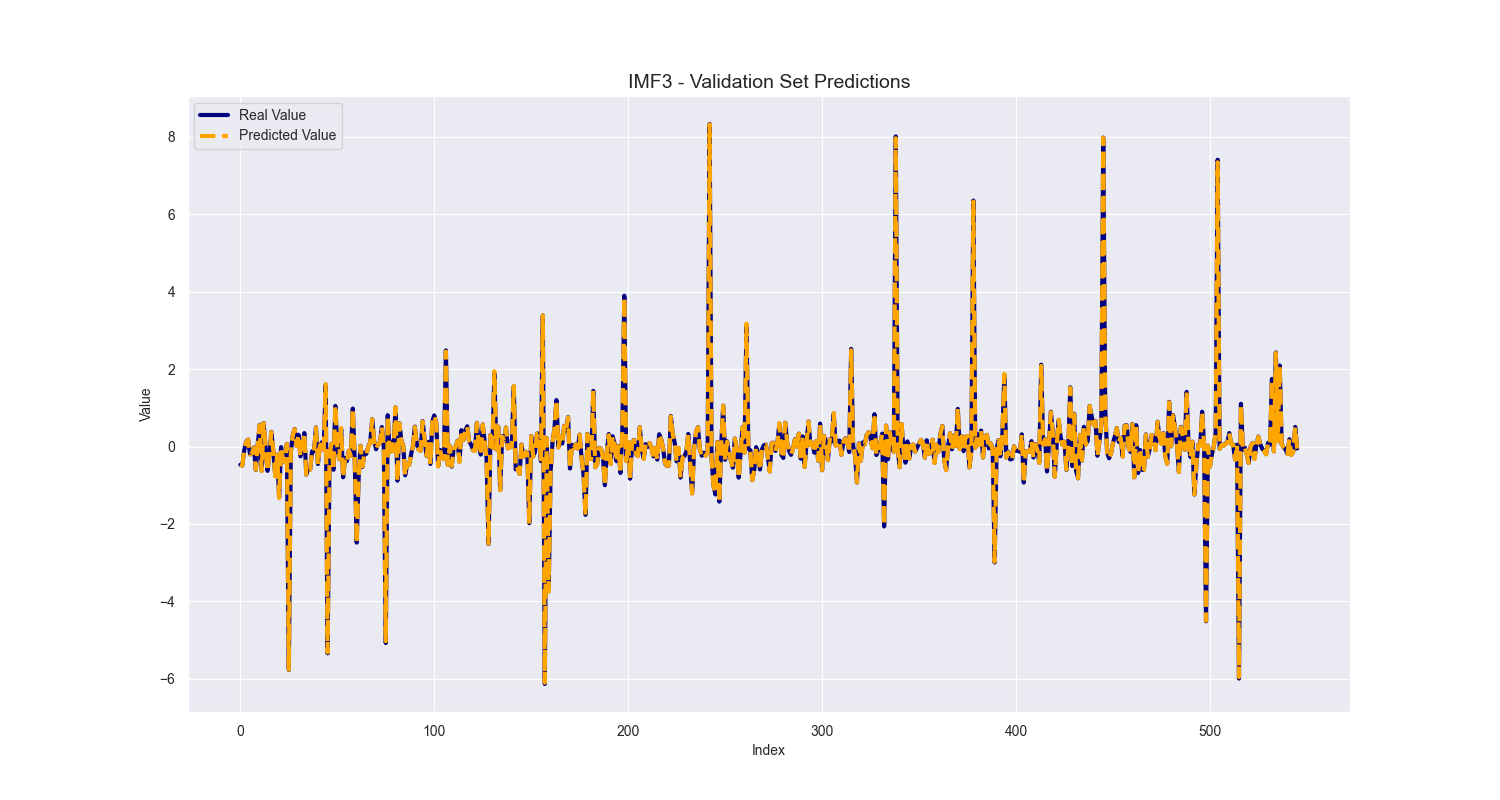

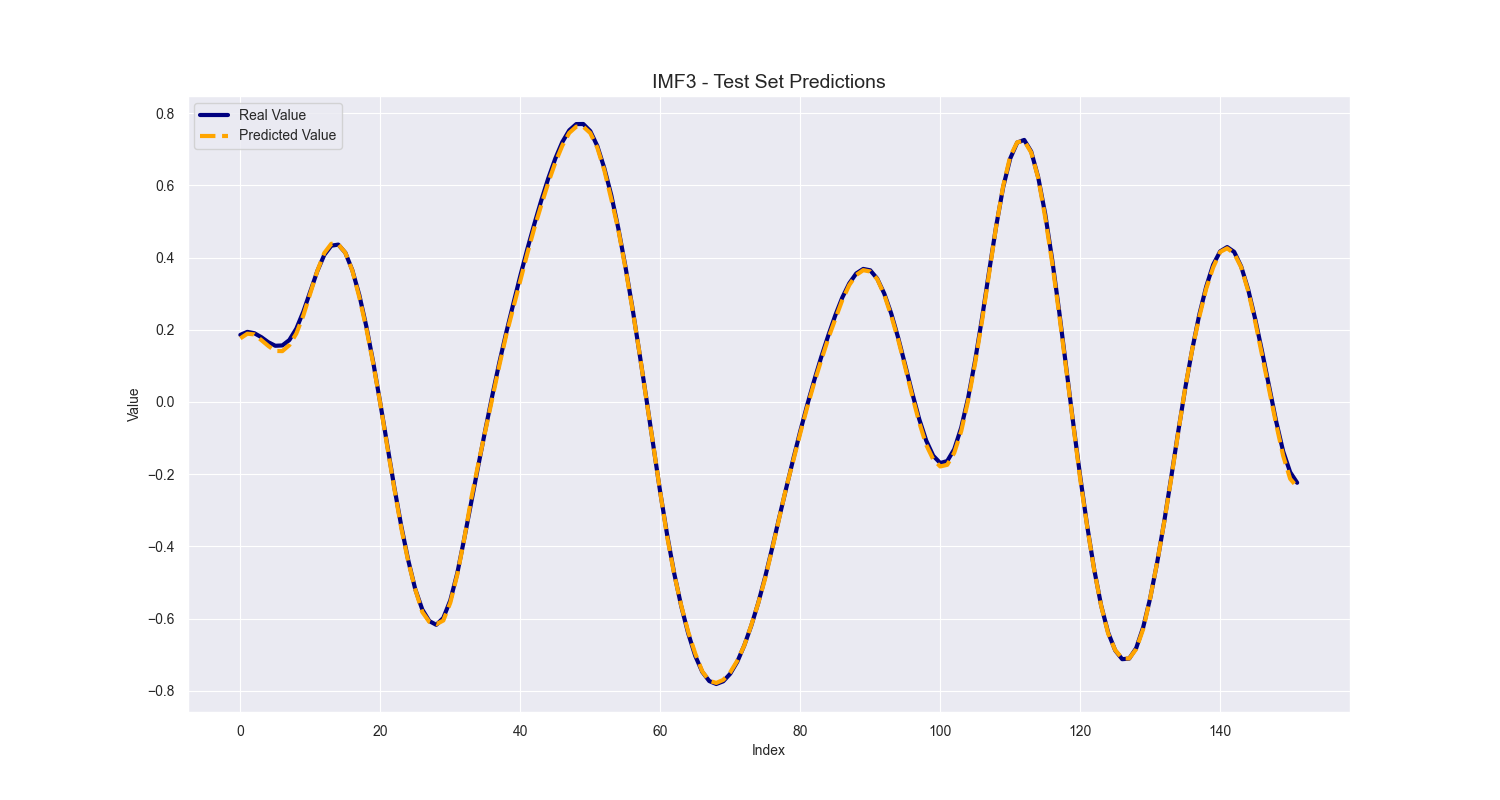

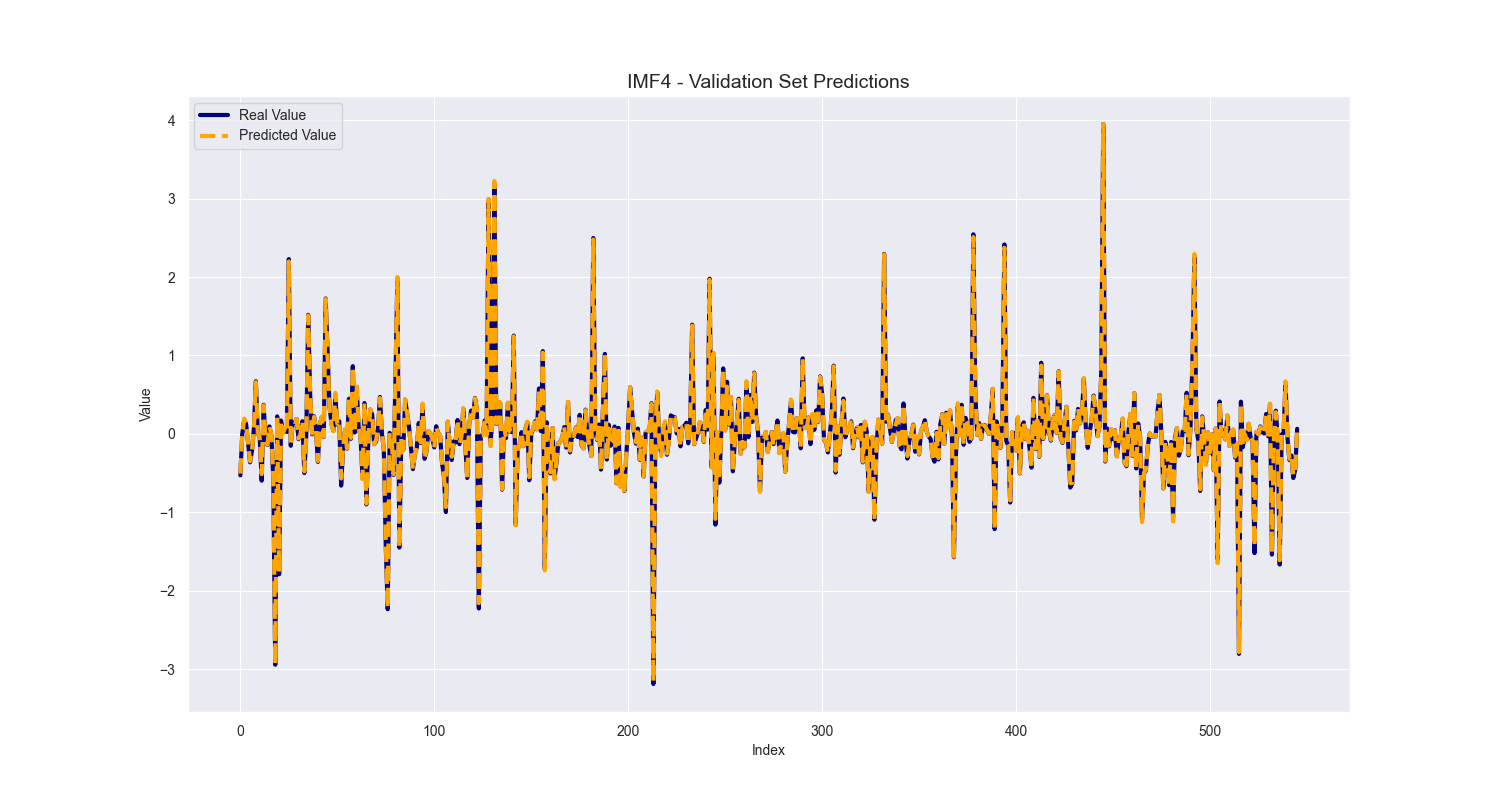

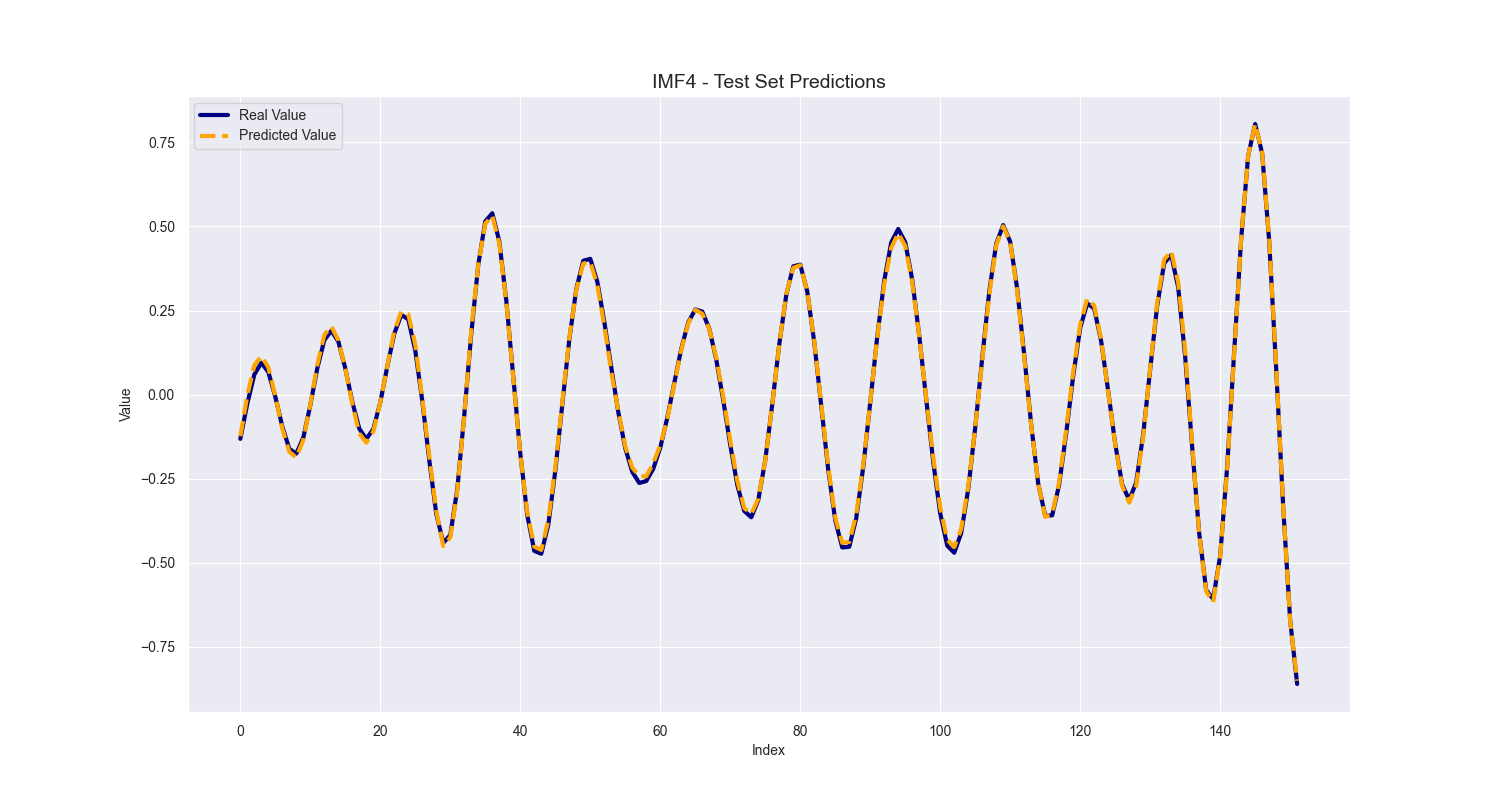

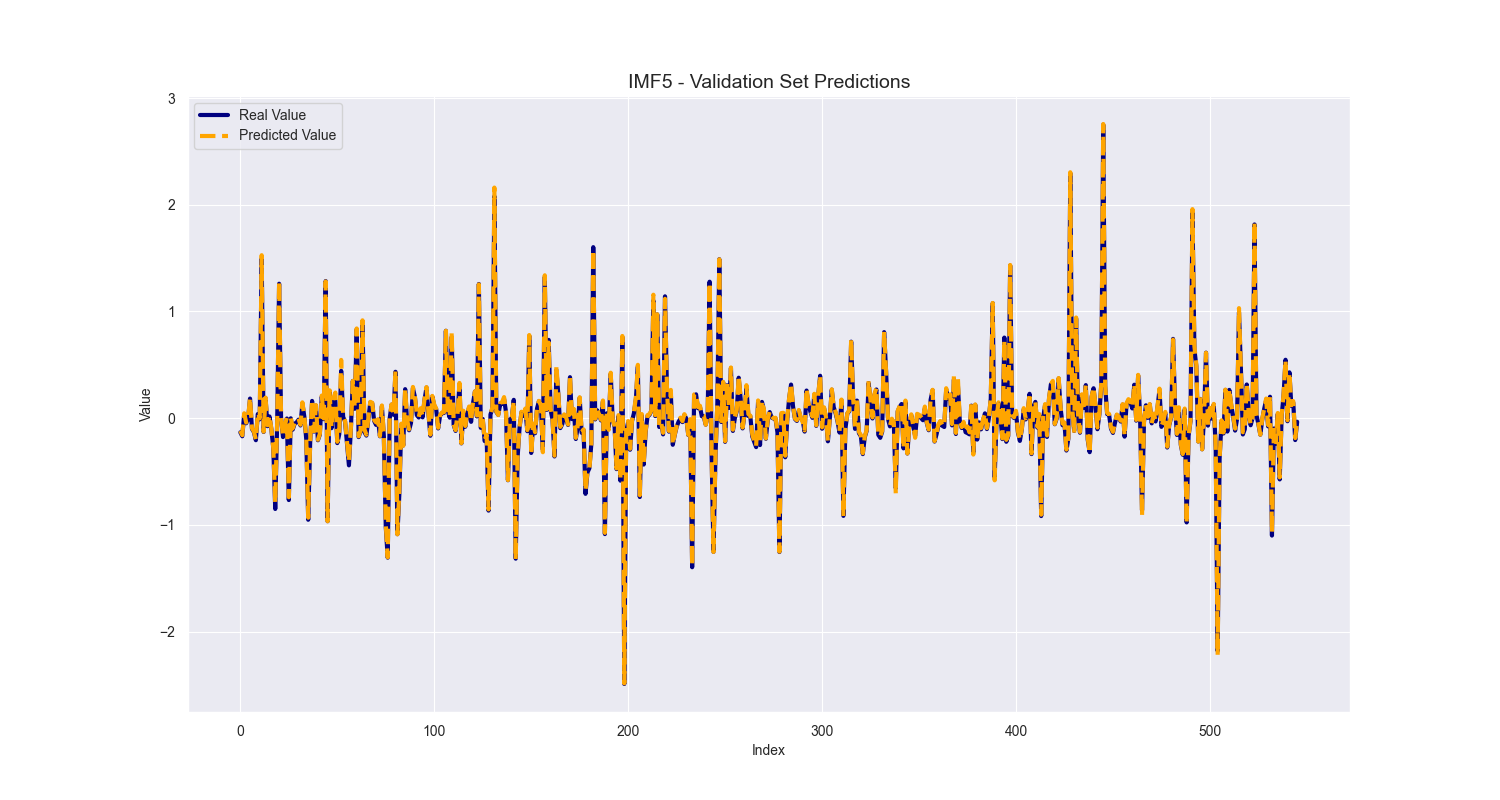

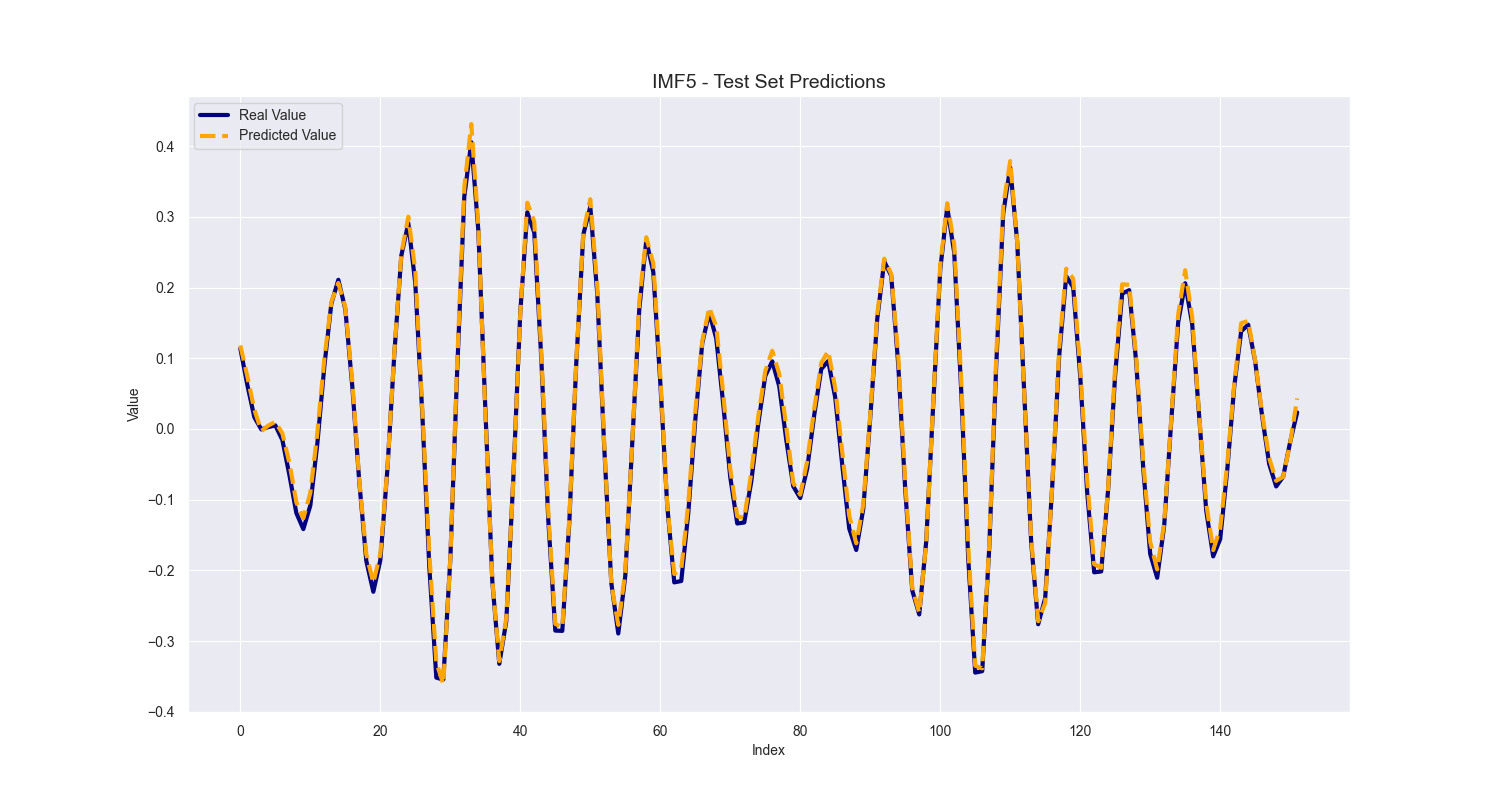

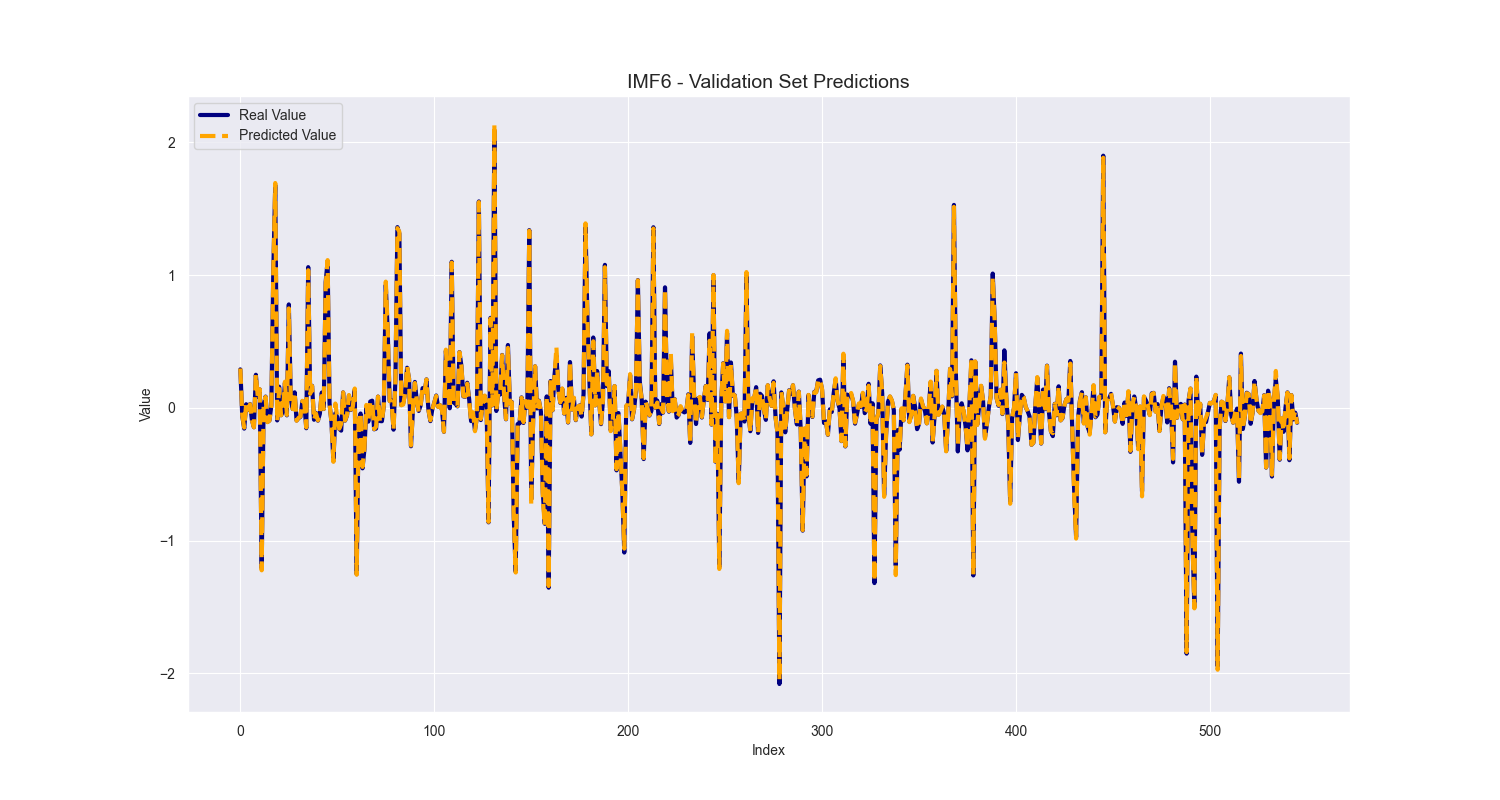

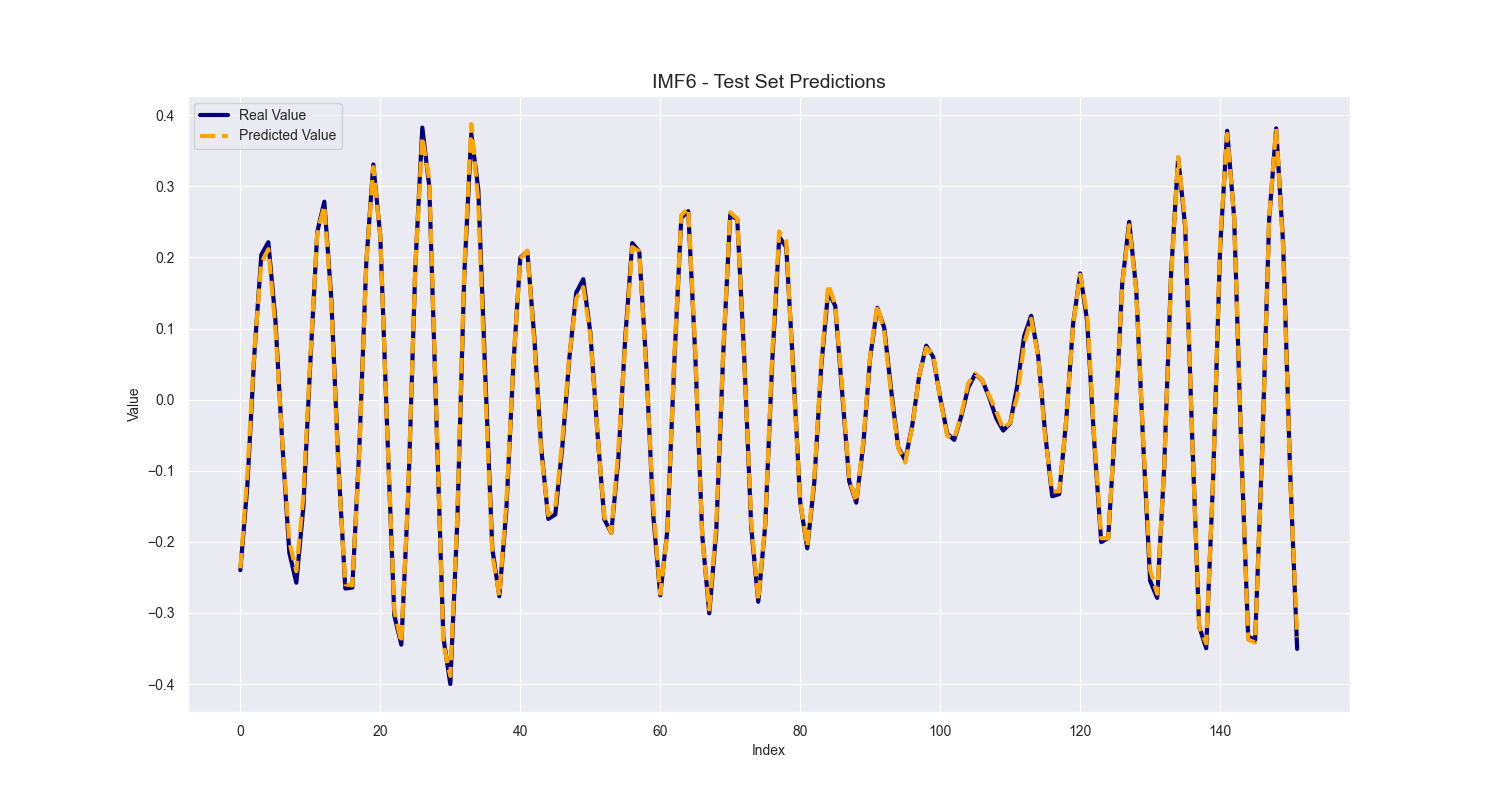

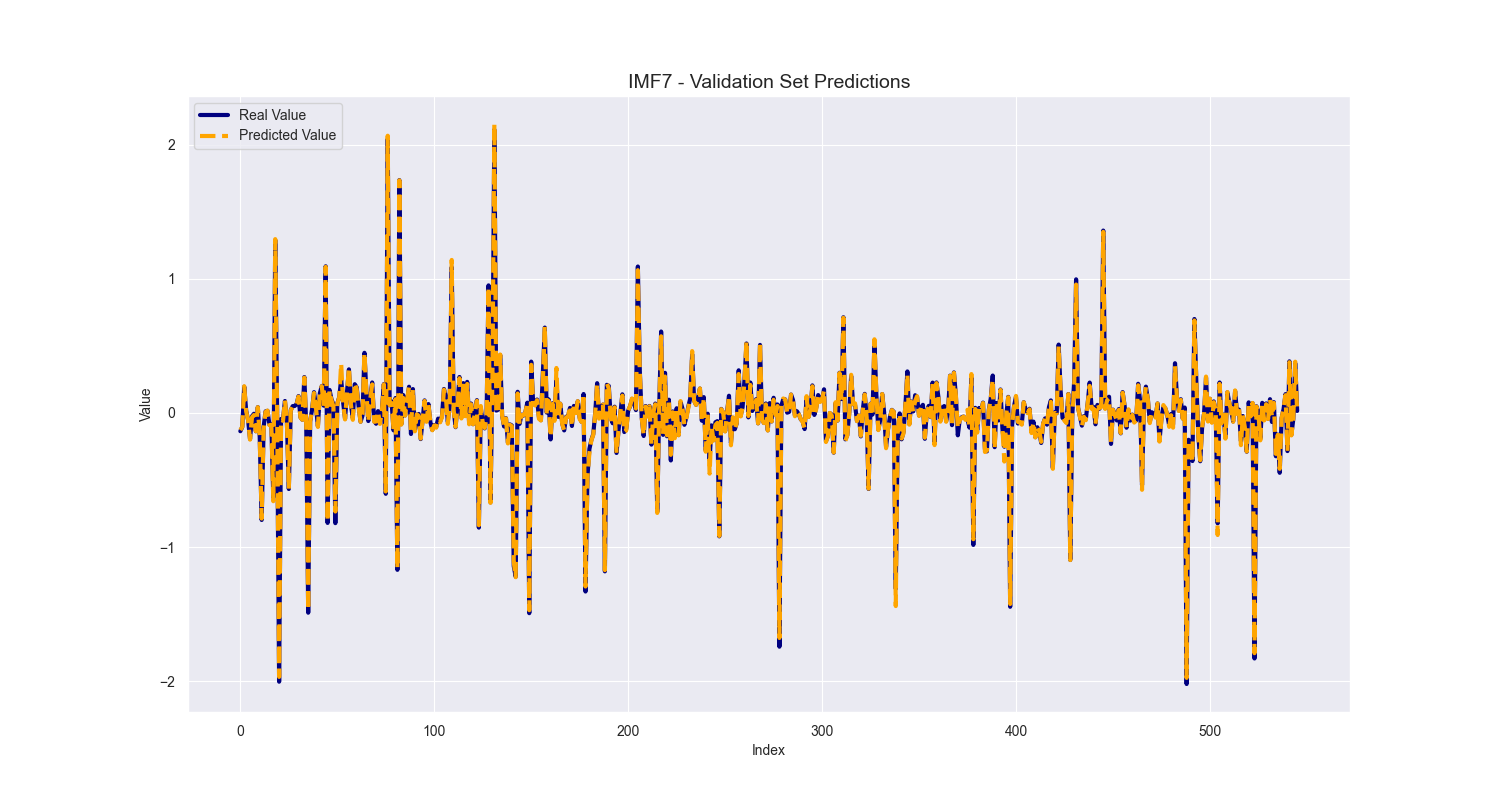

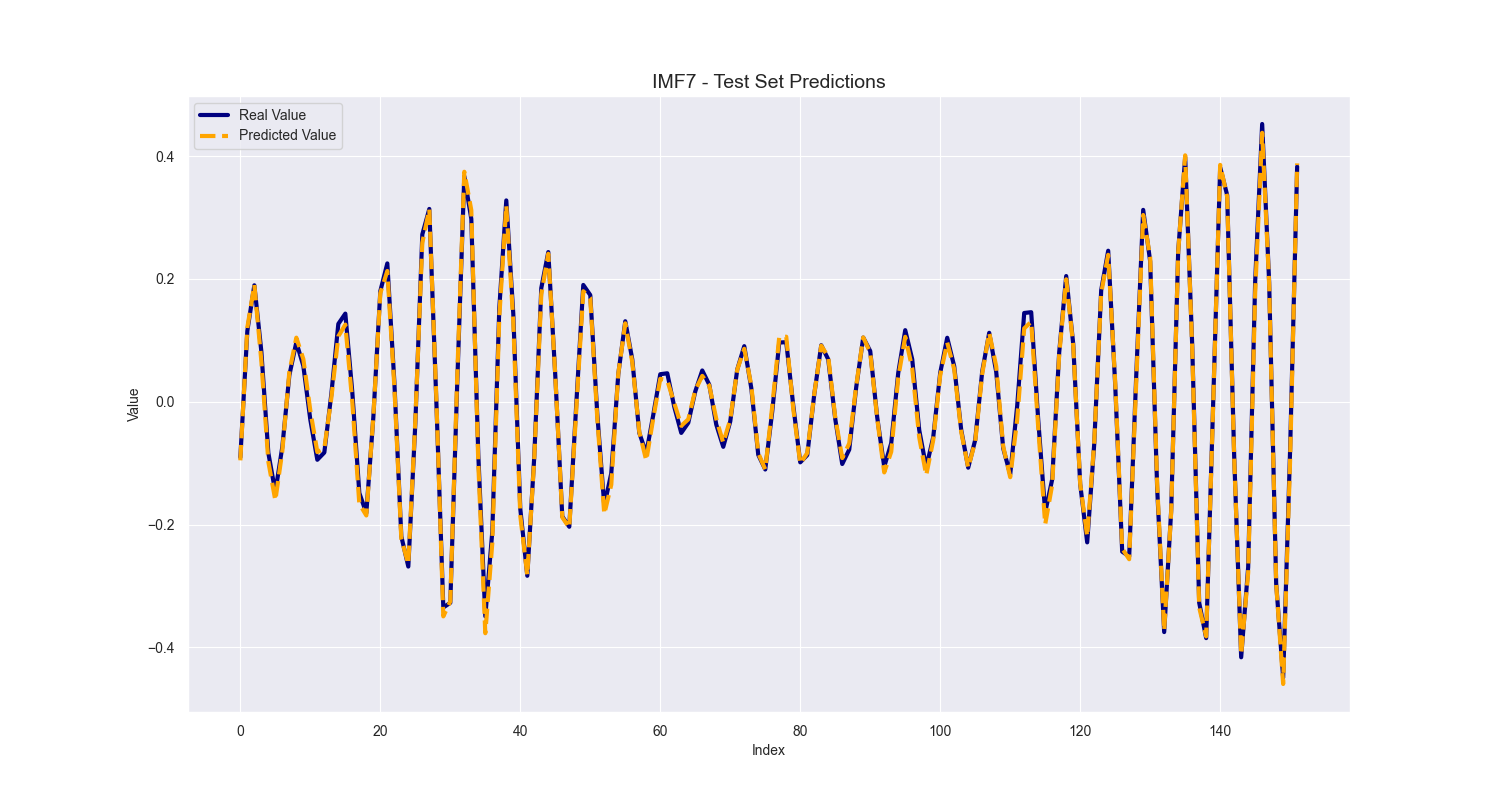

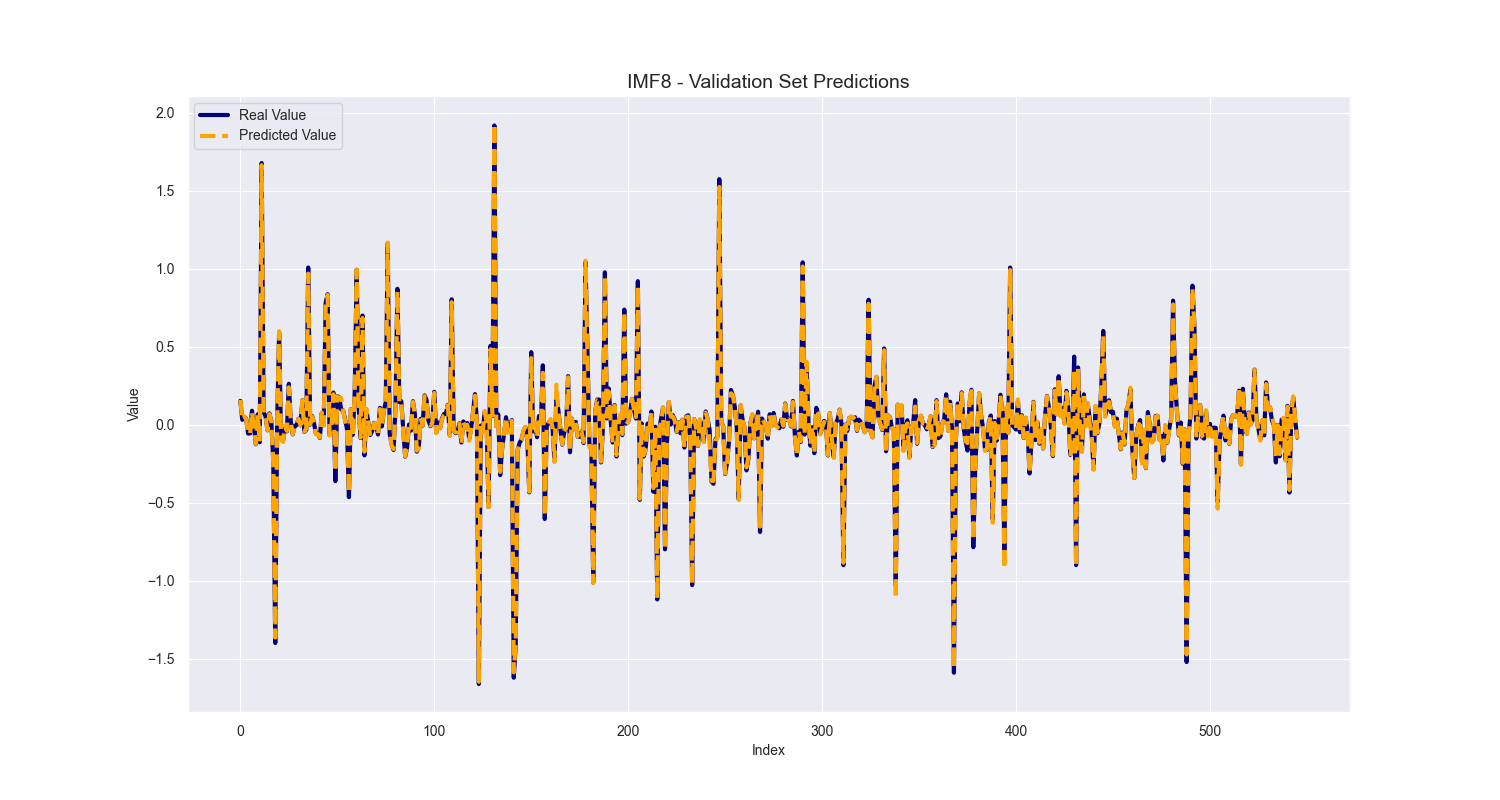

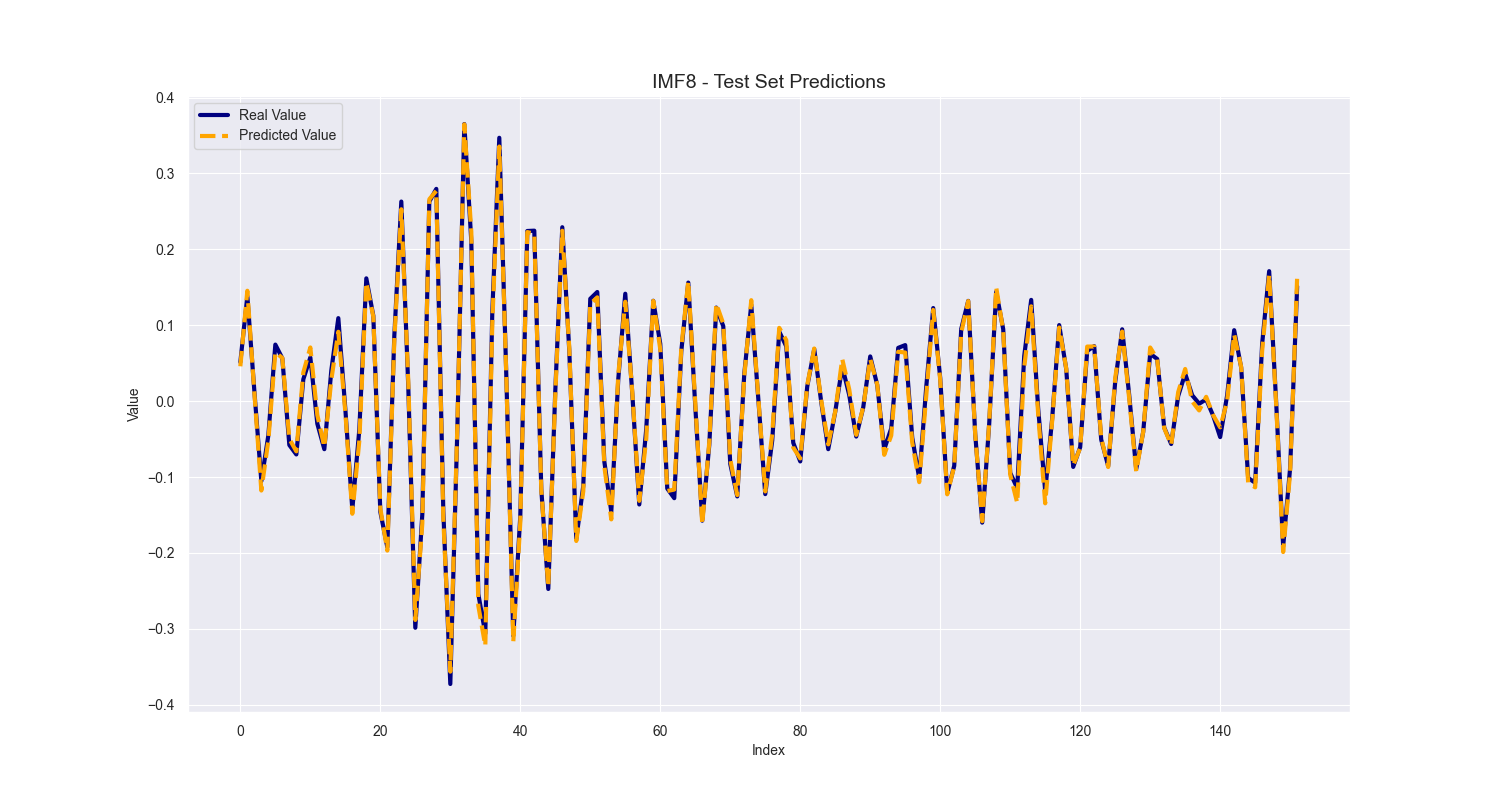

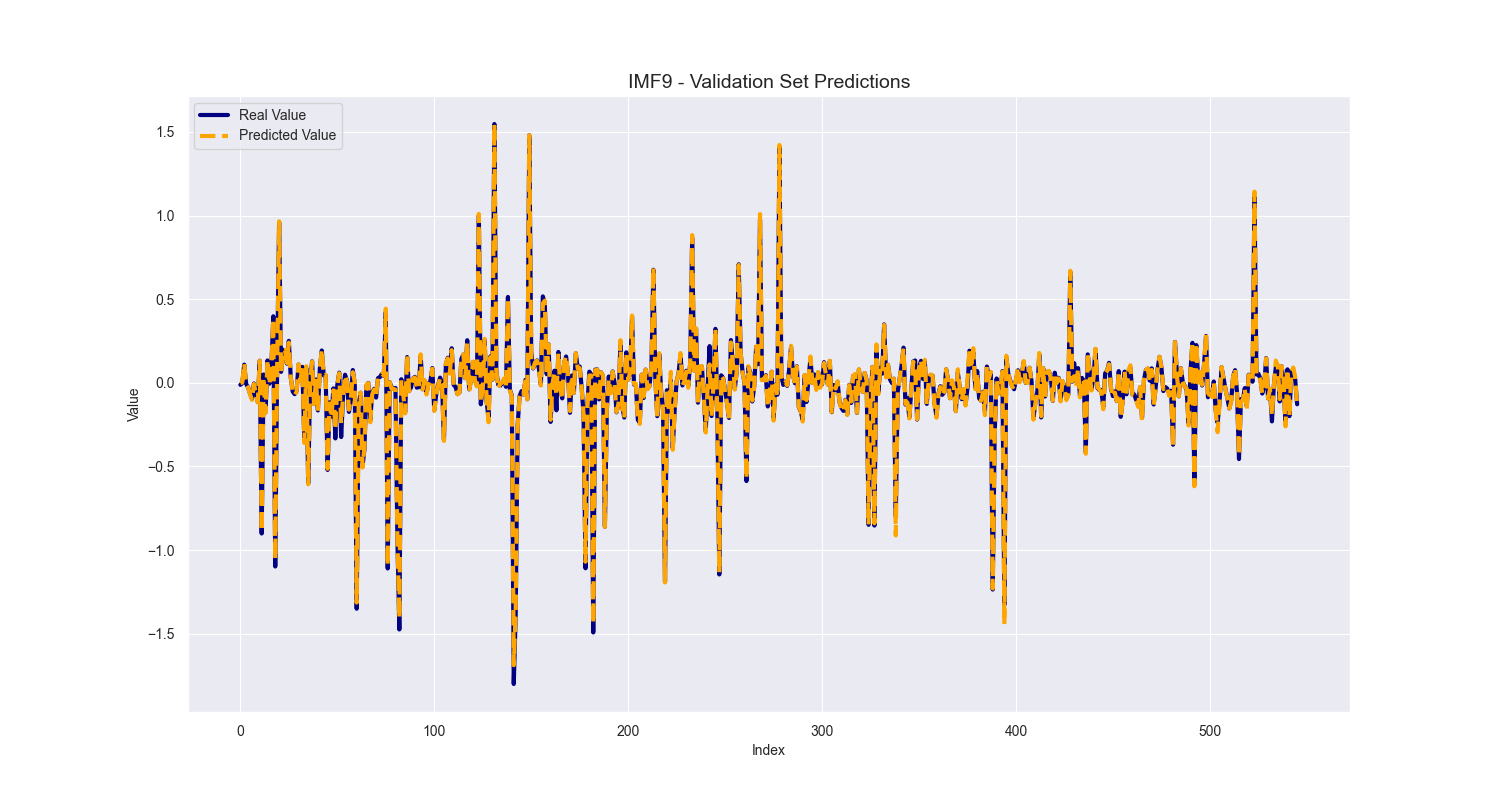

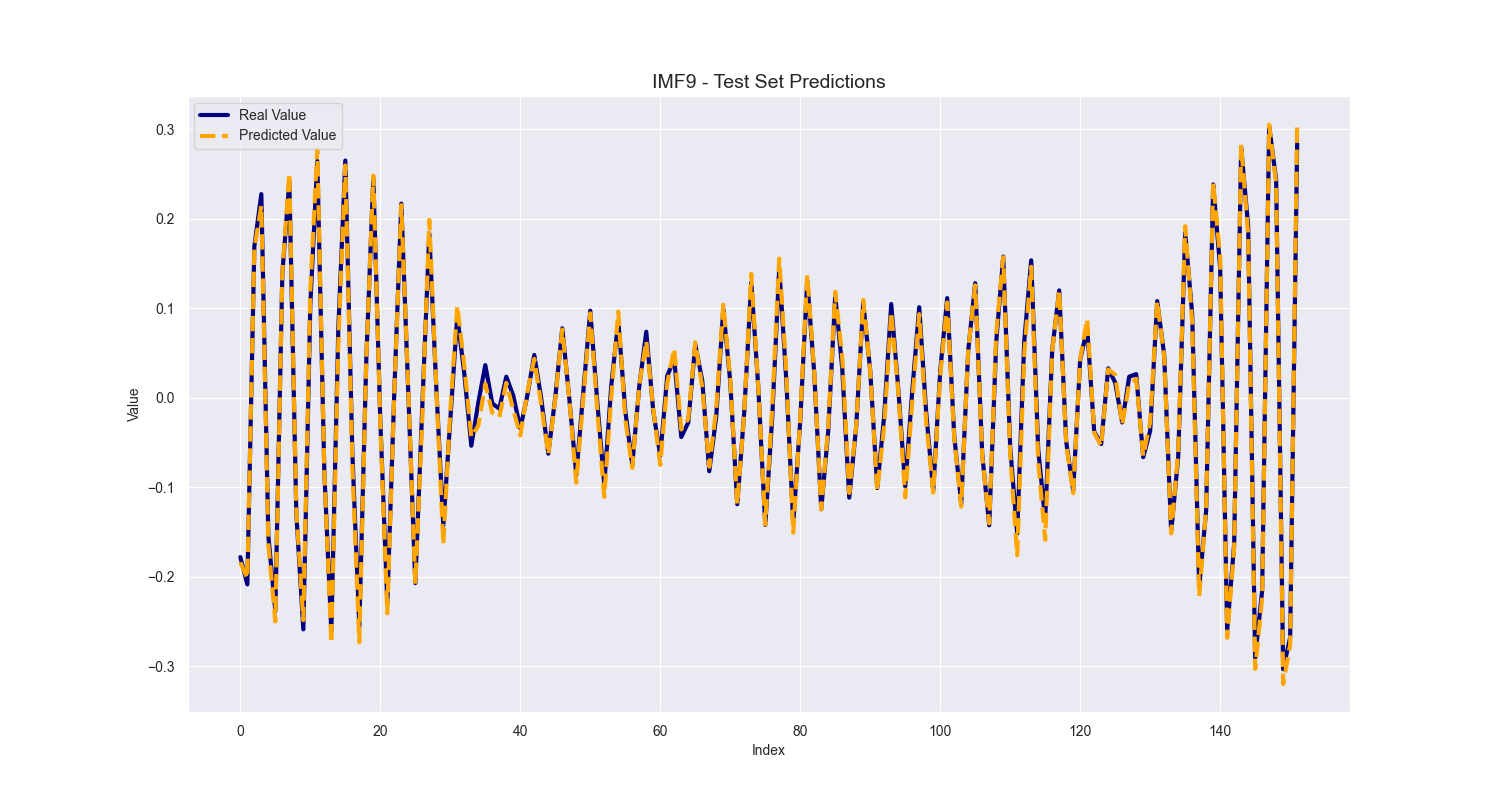

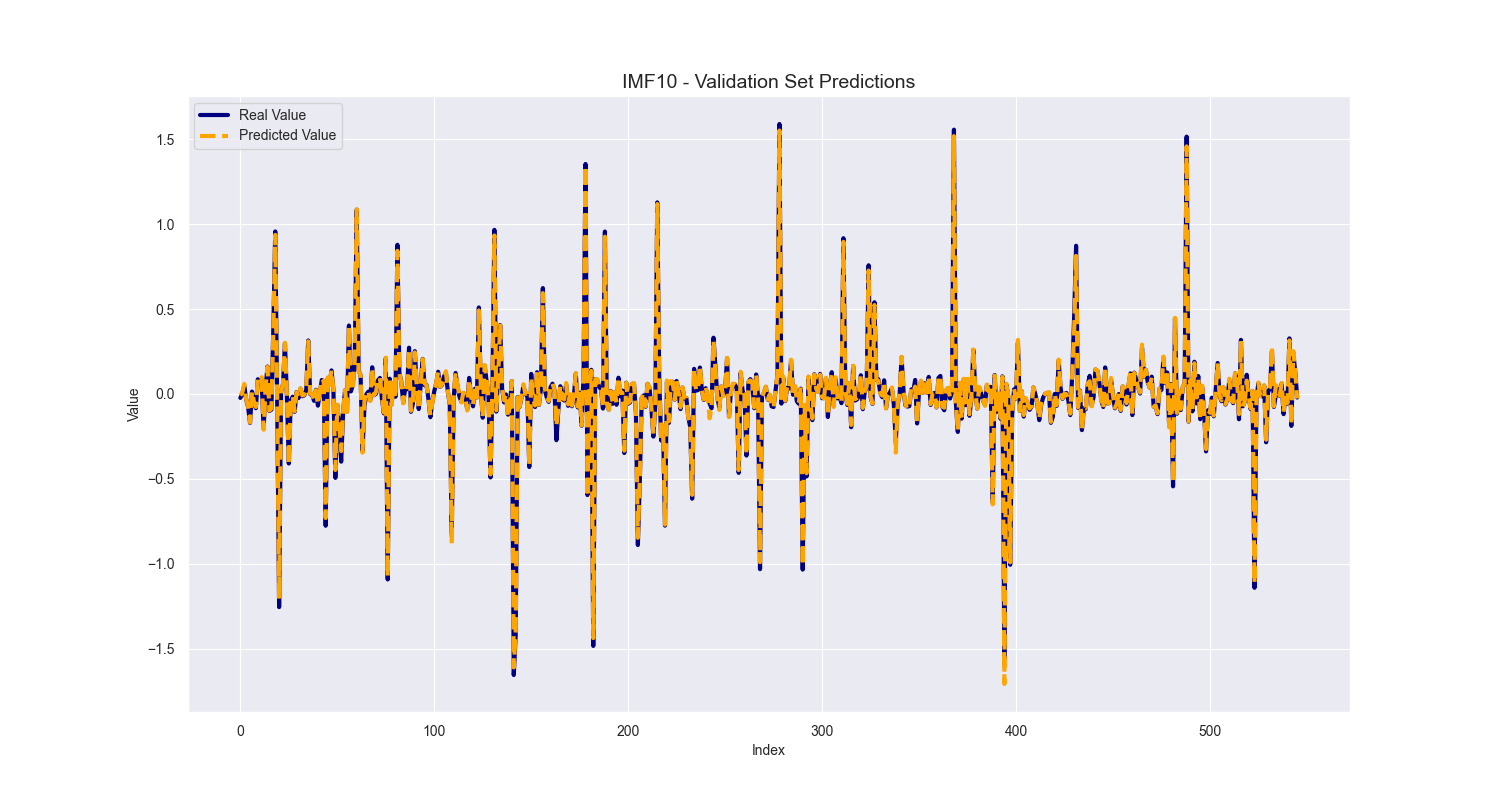

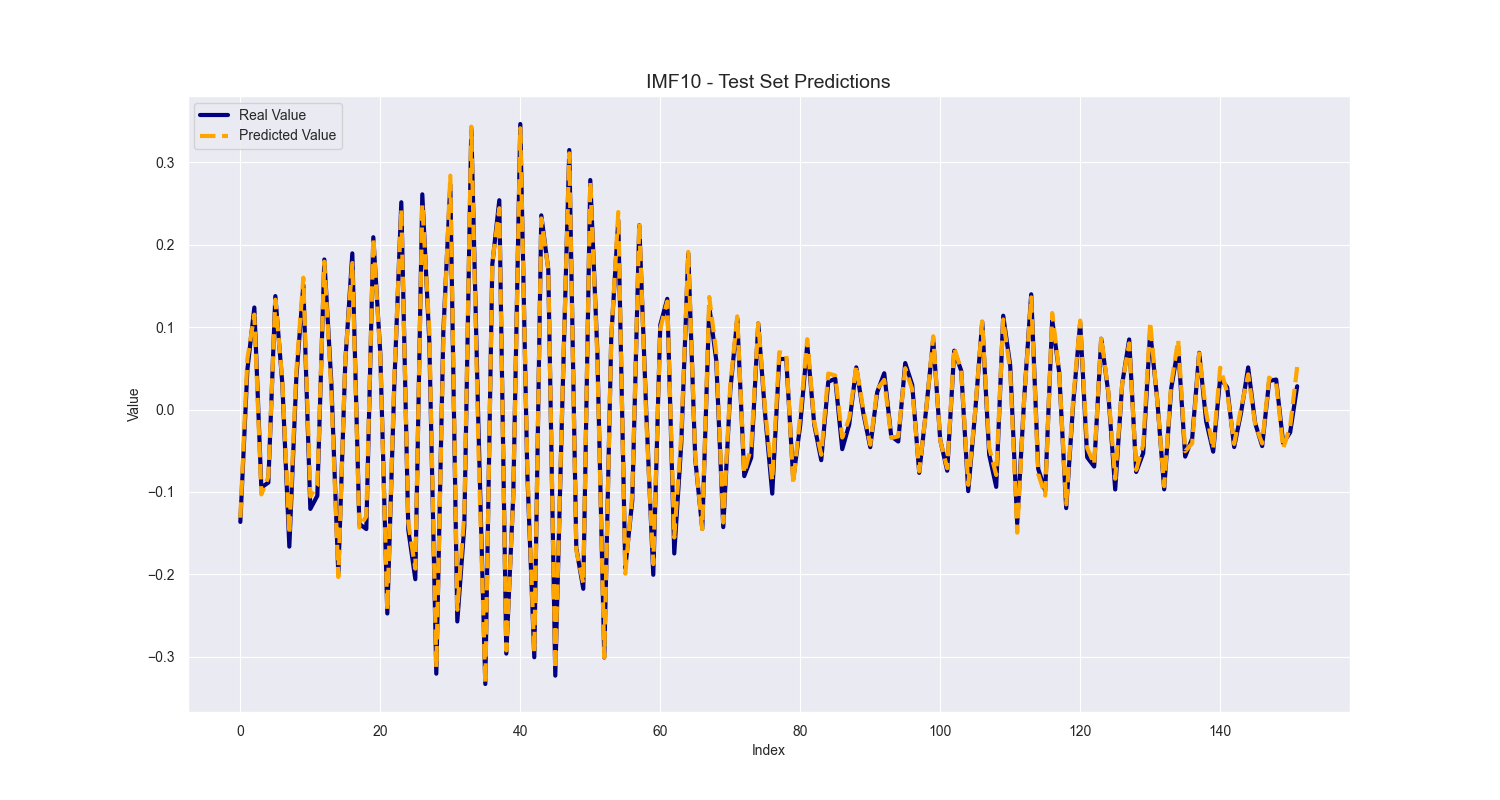

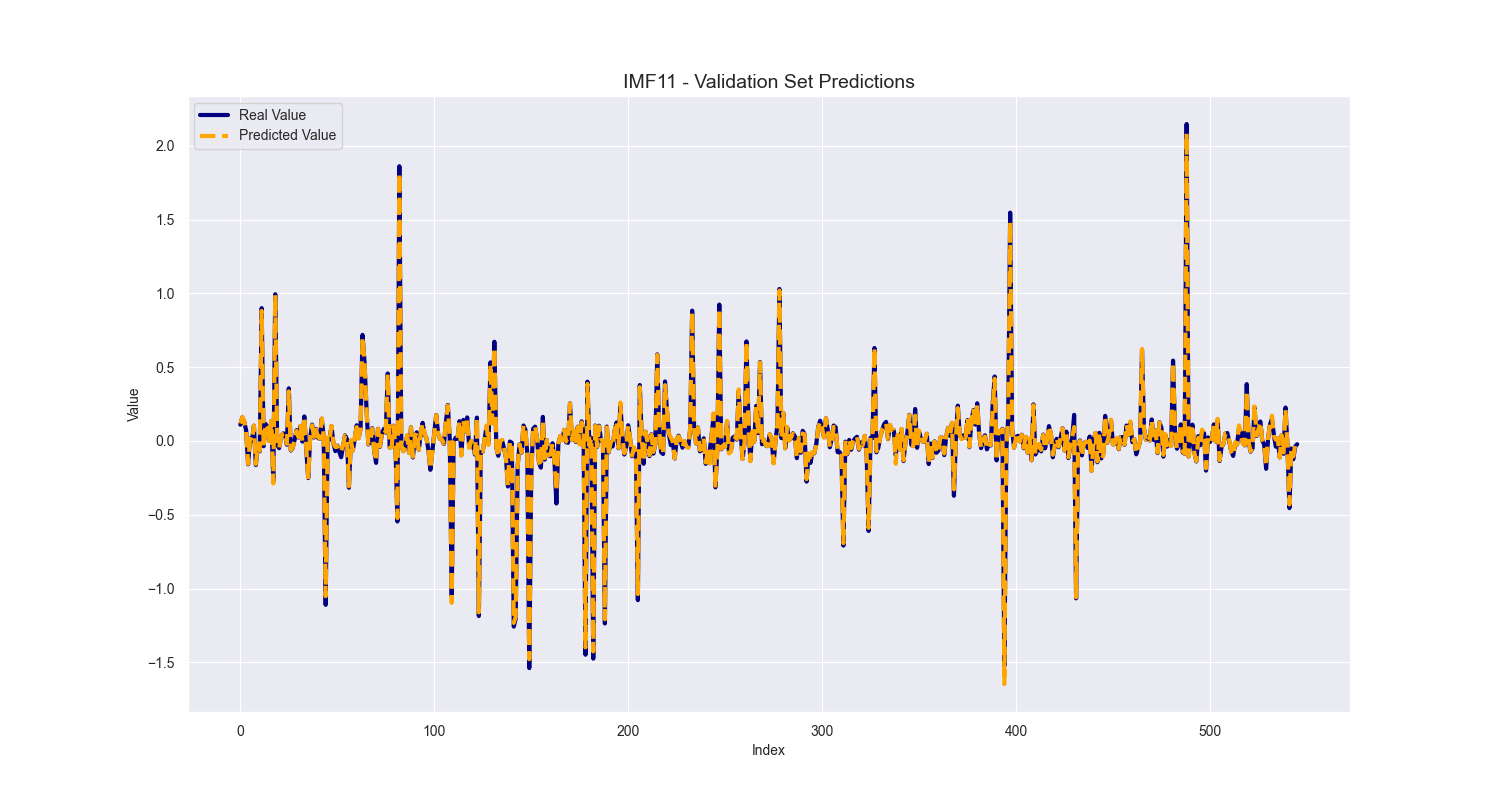

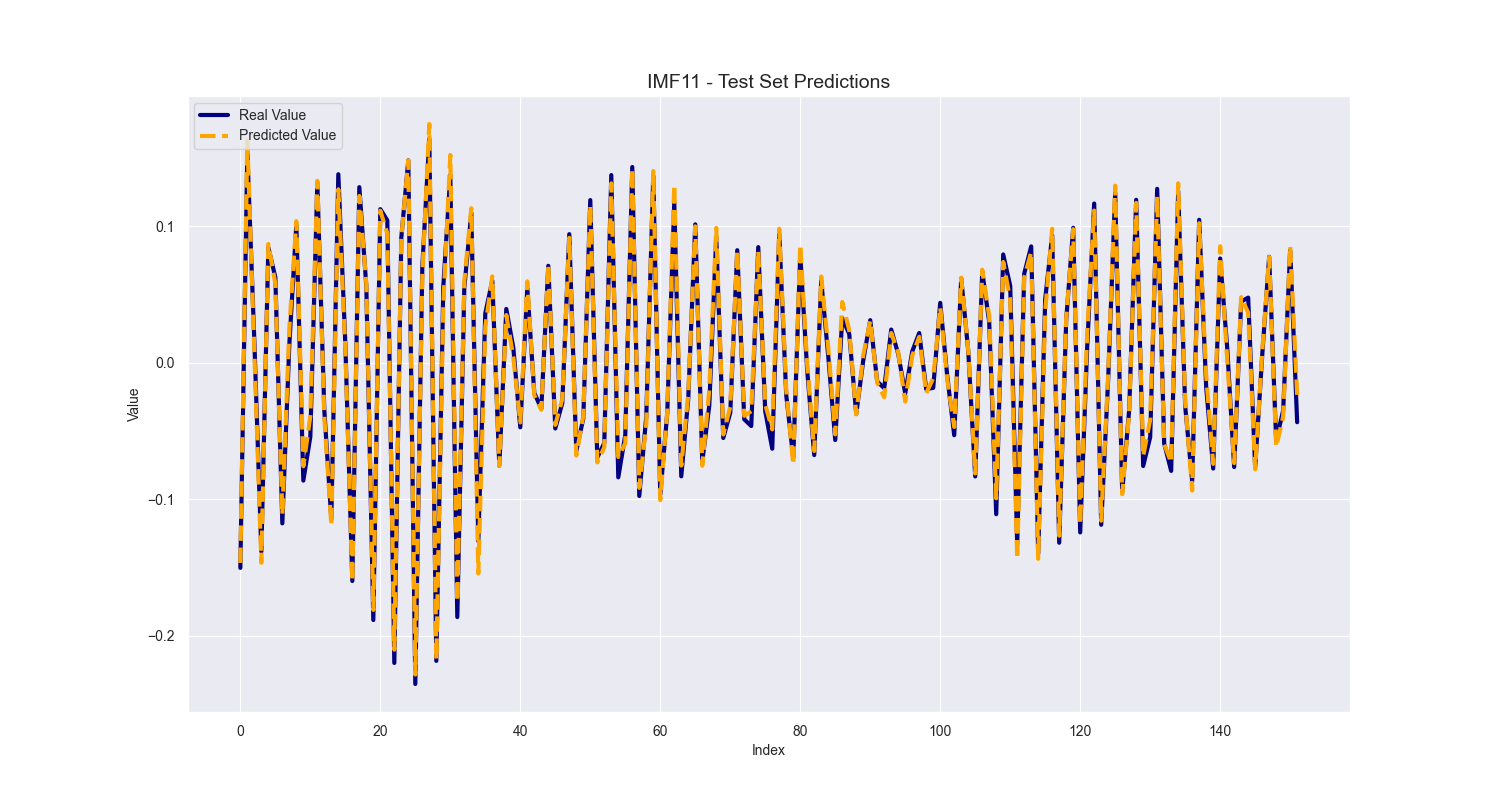

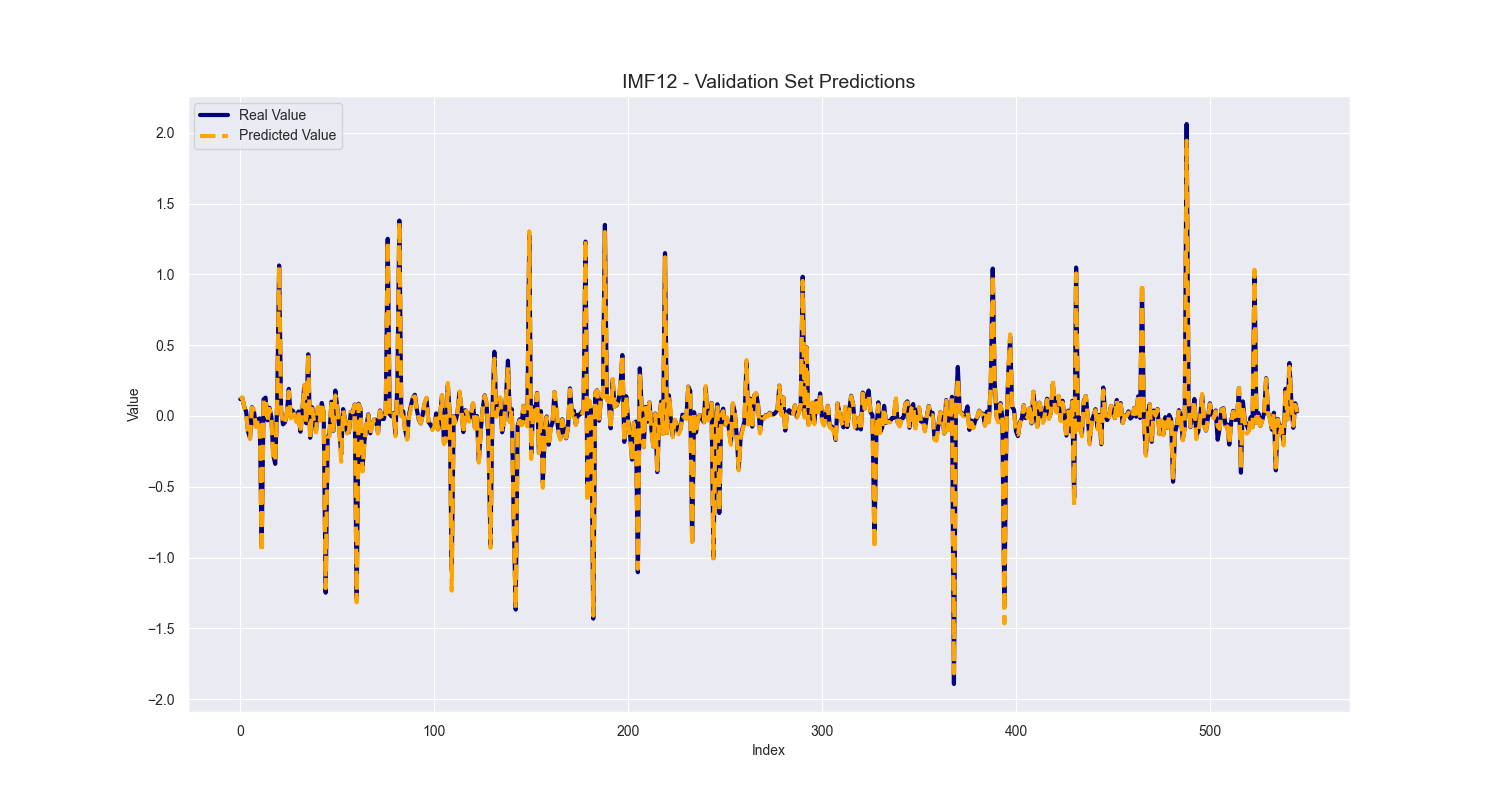

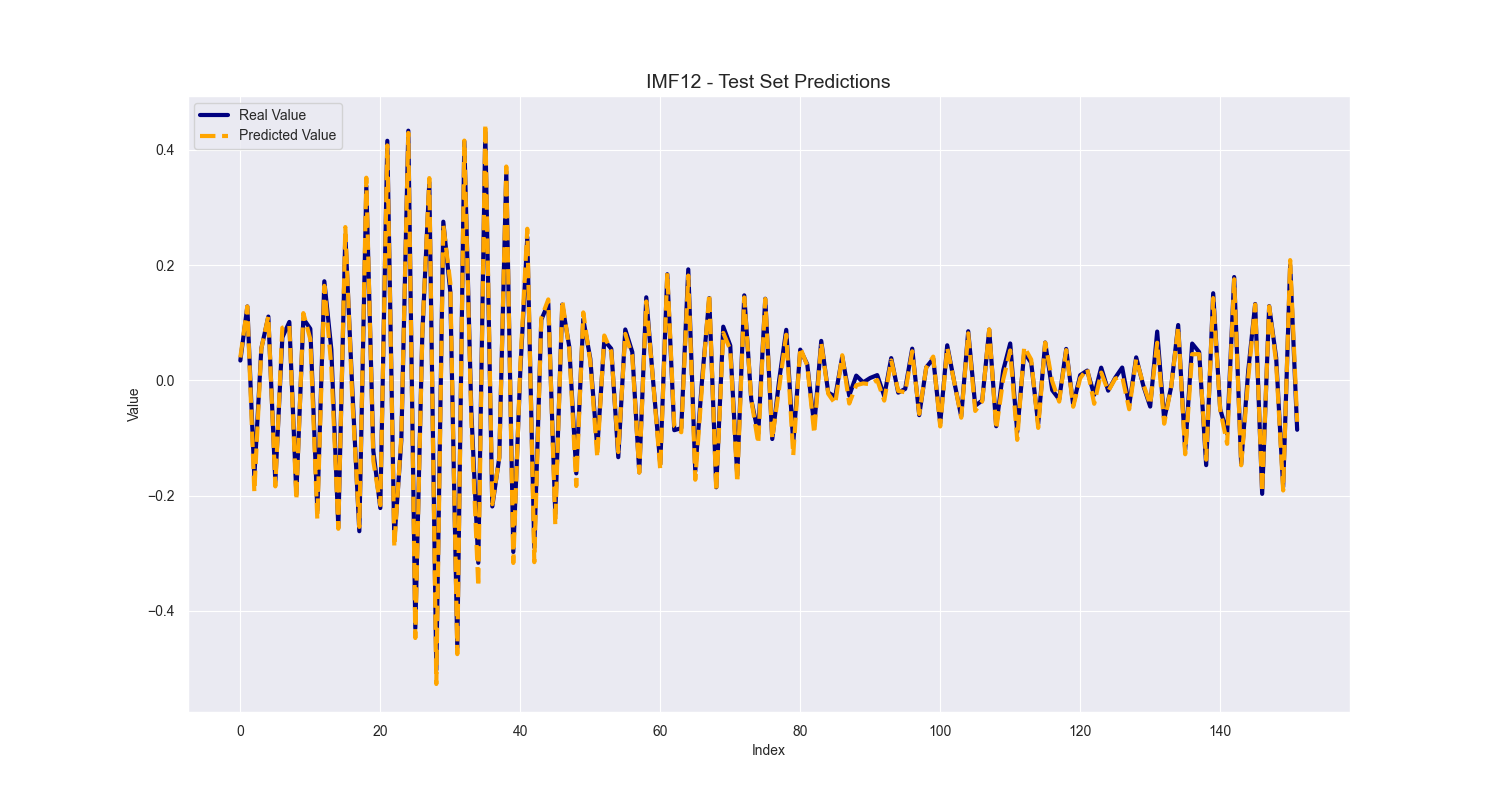

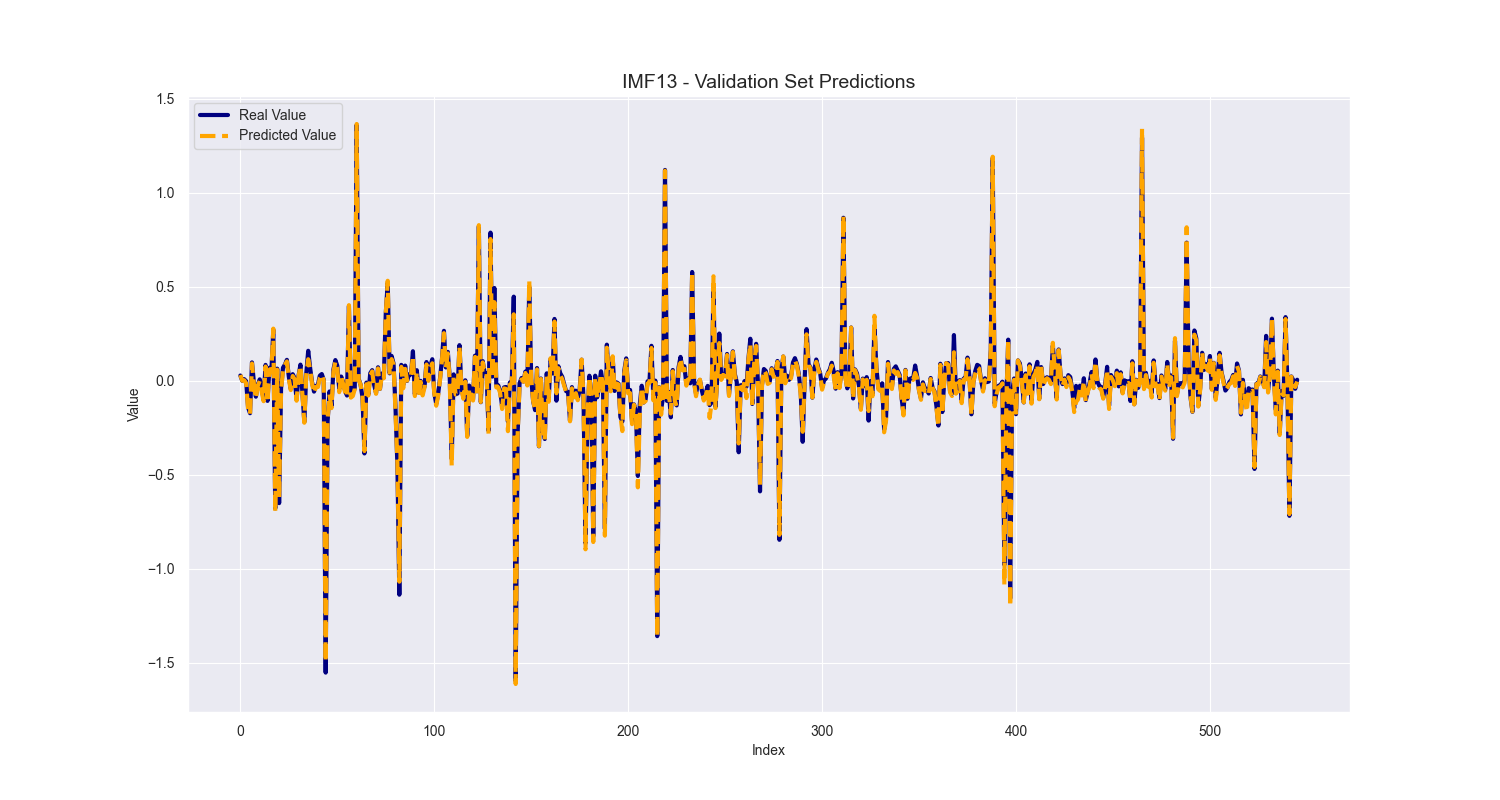

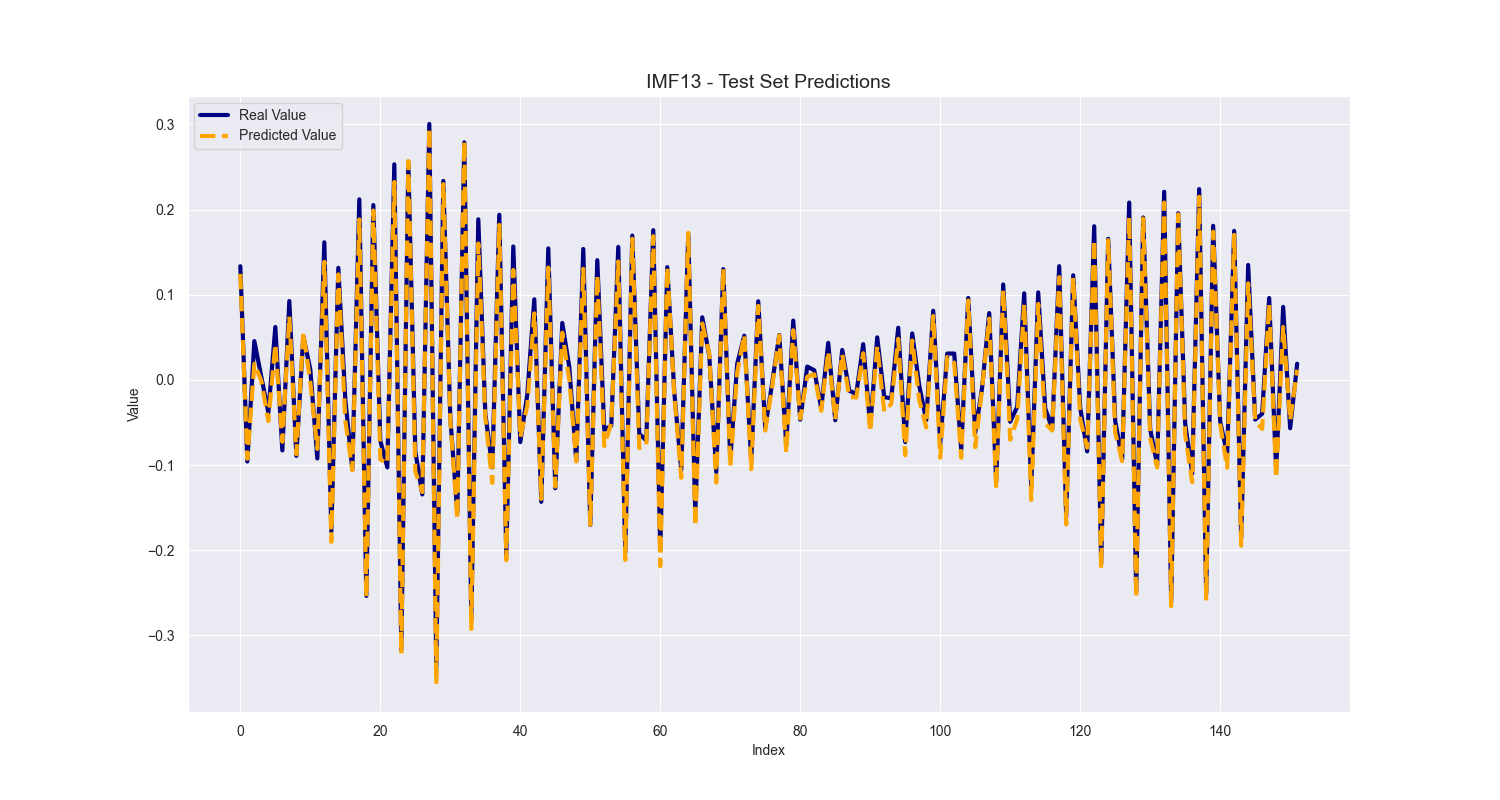

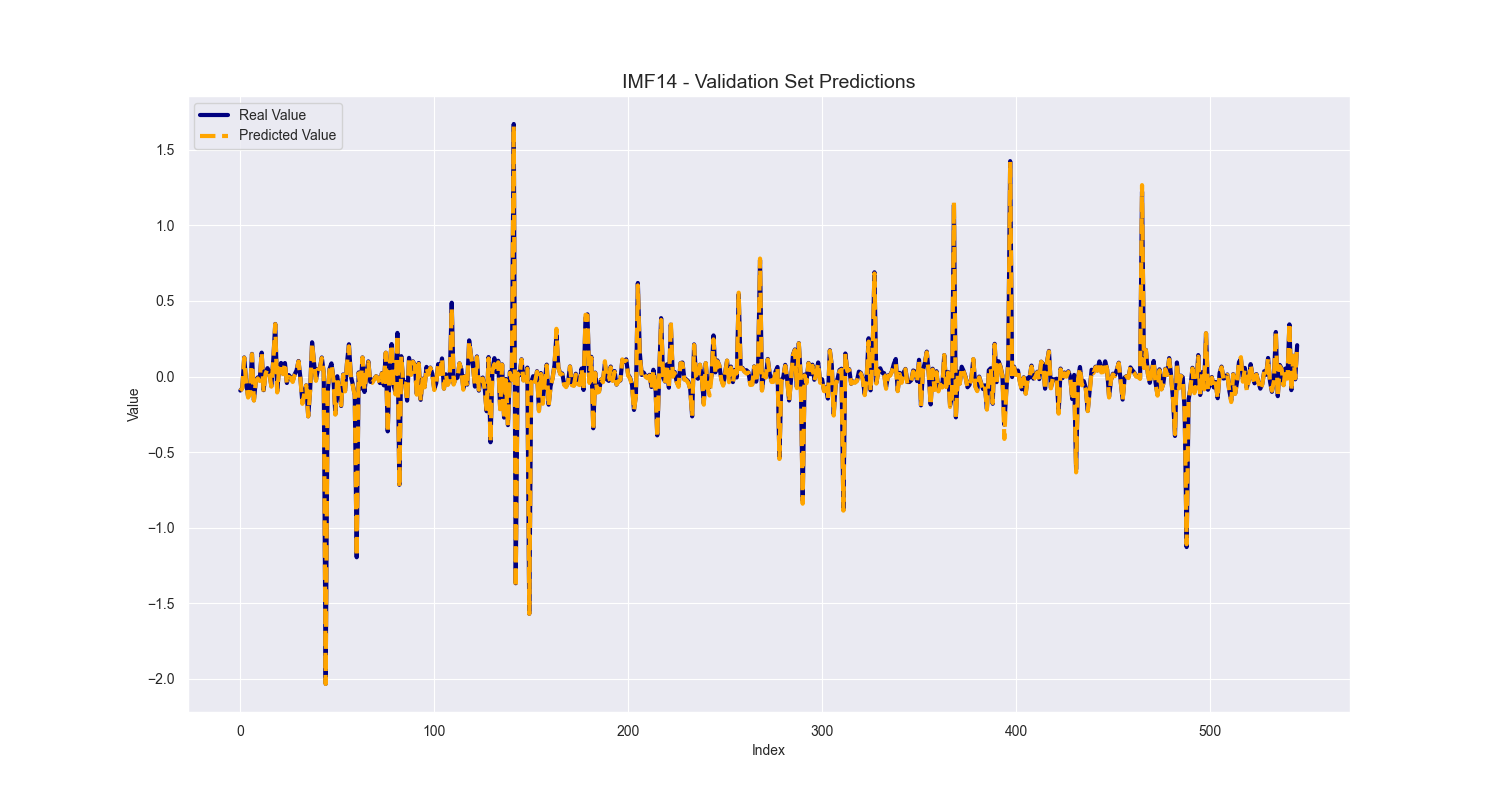

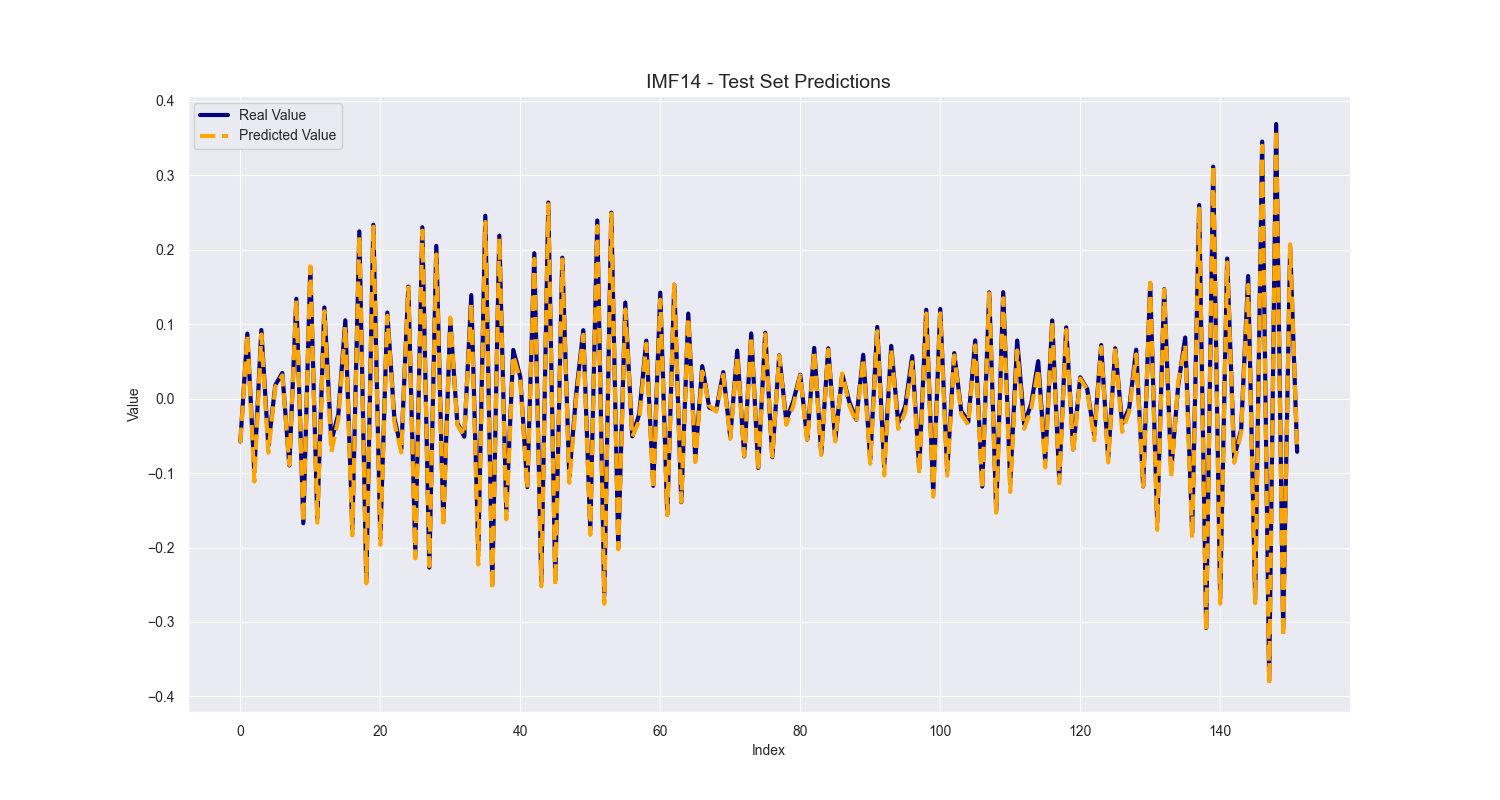

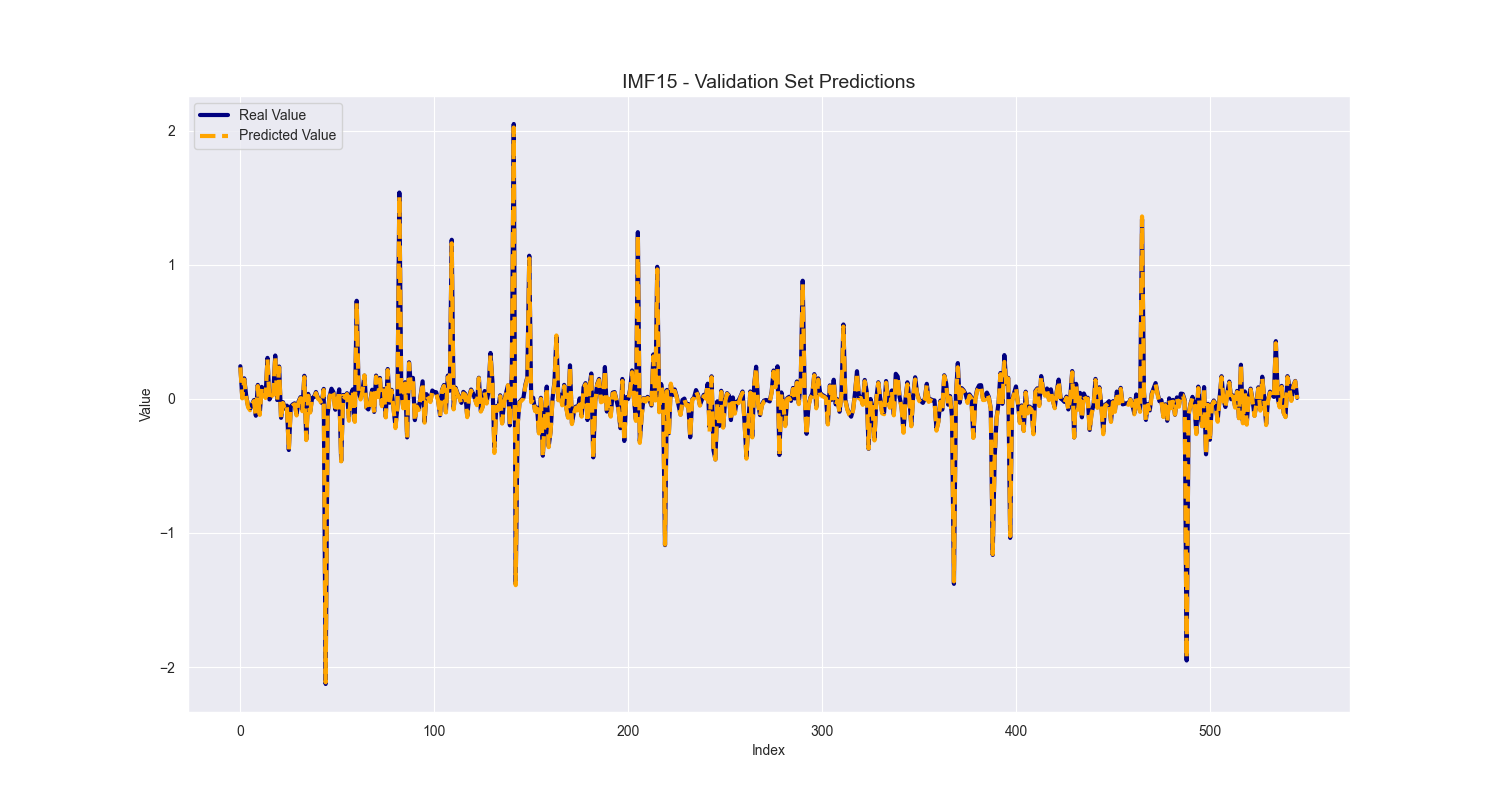

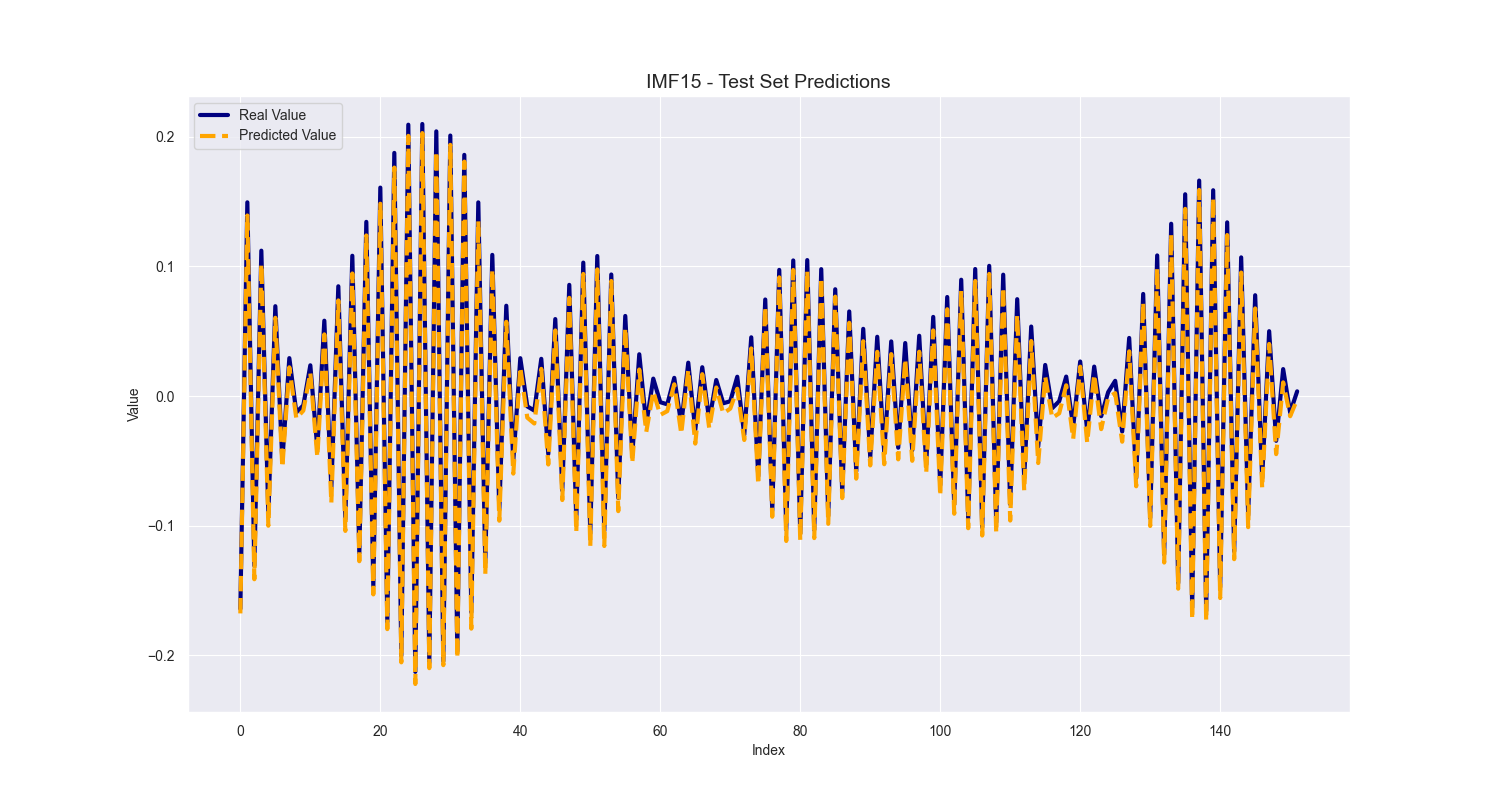

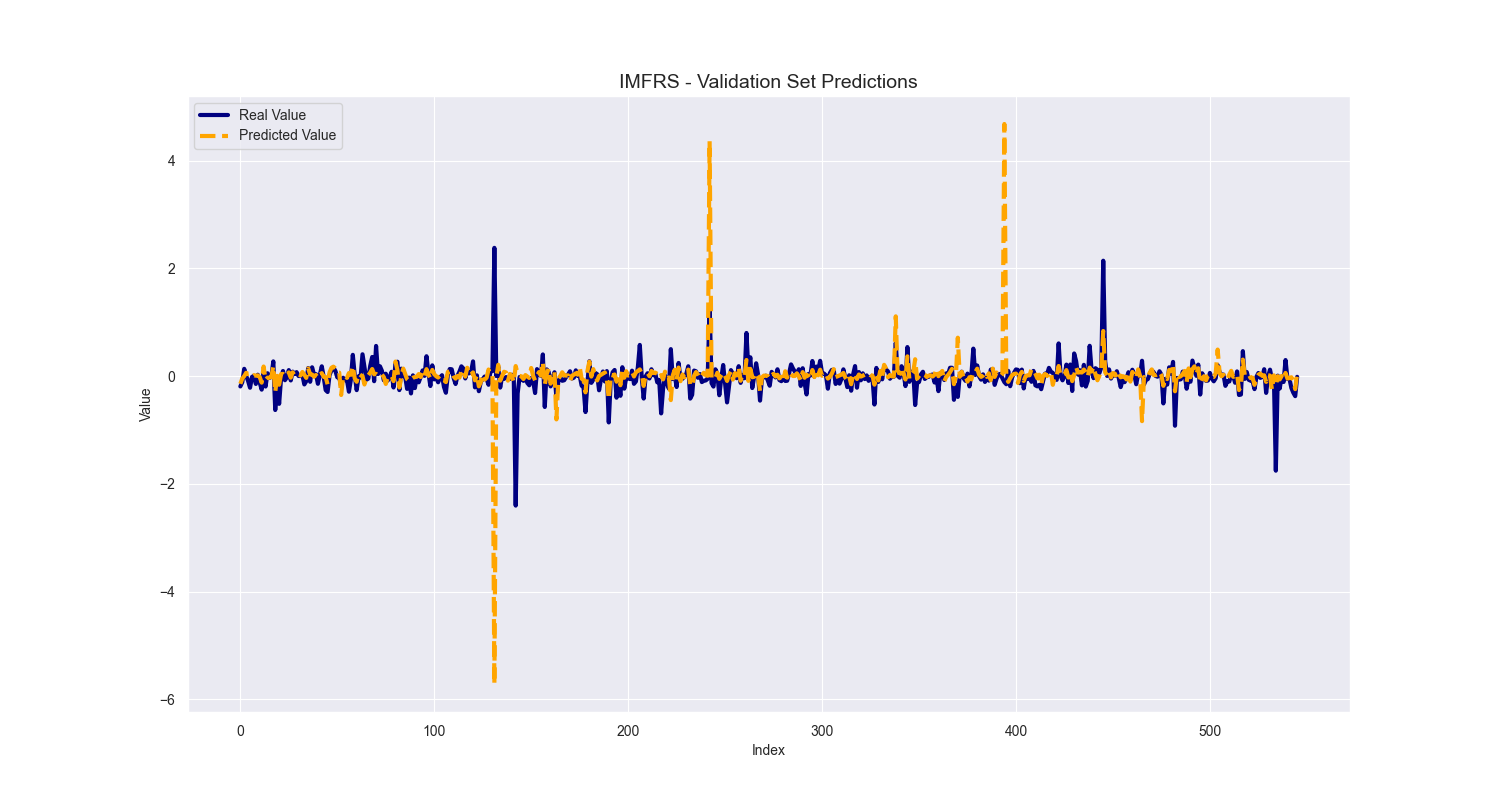

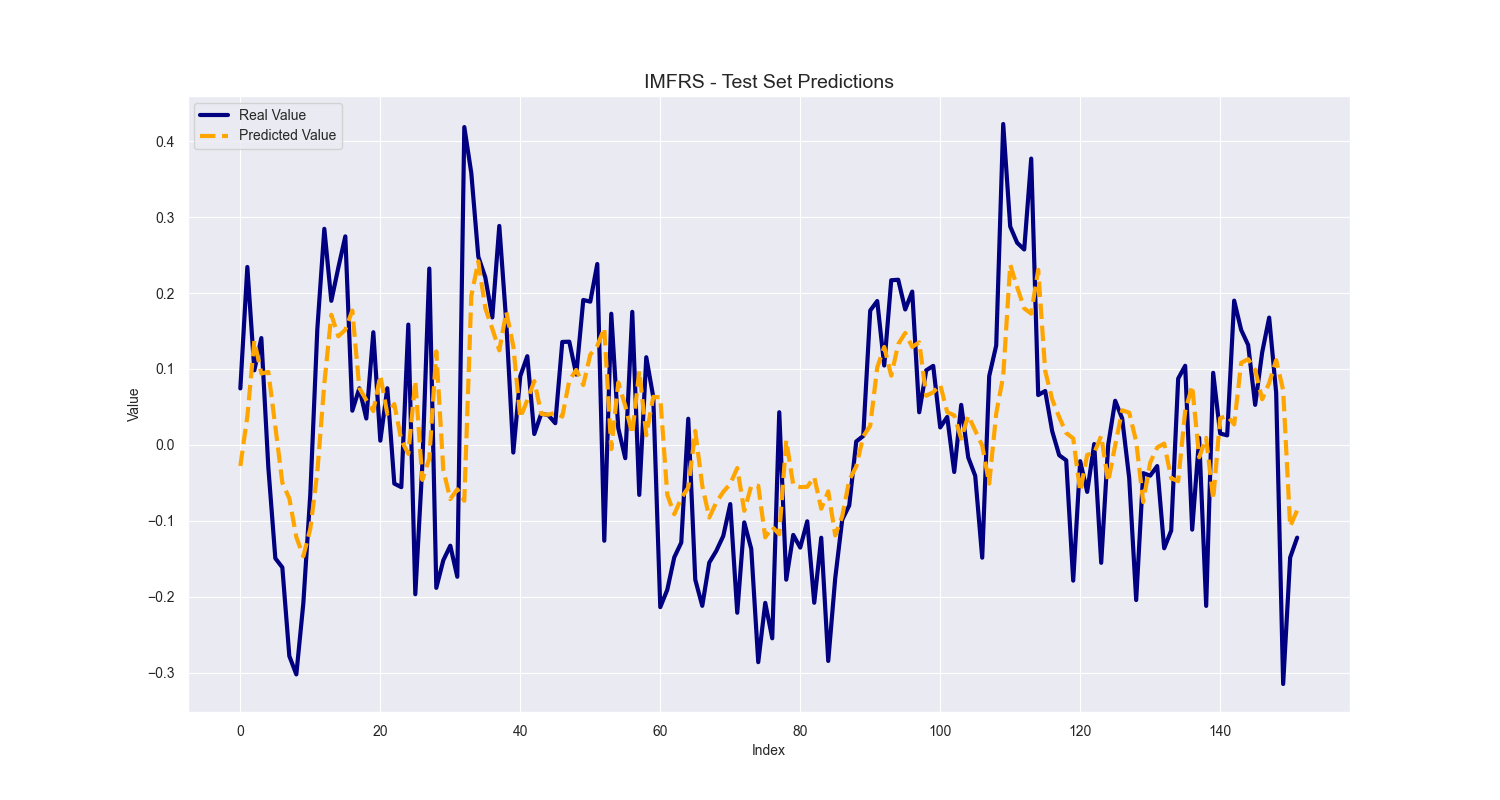

In [51]:
for img_path in saved_images:
    display(Image(filename=img_path))

# Point prediction result evaluation index calculation

In [52]:
Predictions=Test_total_sum_of_predictions
Real = sum_of_Test

In [53]:
Predictions_test = Predictions
Real_test = Real.values
print(Predictions_test)
print(Predictions_test.shape)
print(Real_test)
print(Real_test.shape)

[75.91757224 77.30970585 77.11365864 77.23214488 76.60294624 76.48472458
 76.36369111 76.28445523 75.80175136 76.02862633 76.84914757 76.78244158
 77.91760189 76.97286259 77.4594452  77.72336211 76.39158    76.10573568
 76.53106919 77.11790729 76.39623654 76.20242981 76.2725853  76.10591497
 77.17874638 74.58343966 76.90982381 76.97417918 74.47048509 74.1658069
 74.931239   74.34018099 77.98335201 77.93656007 76.59969738 76.59867267
 76.28871776 77.25106659 76.75166488 76.23737832 76.73938117 76.91006985
 76.45200585 76.27728888 76.74013249 75.22044998 76.78763323 77.1747937
 76.40721157 77.76262119 77.8233376  77.46699203 75.35649916 76.08575577
 75.77811285 75.64392449 75.8139799  75.46400225 75.35852195 75.16182722
 74.43029564 74.51147009 74.40673497 74.1750521  75.53248137 74.41728177
 74.25506738 74.48258837 74.31531    74.66798922 74.33553683 74.36185914
 74.31278432 74.44190301 74.35335001 74.65582503 75.01052799 76.74097923
 76.56813006 76.07113309 76.31706802 76.896203   76.8

In [54]:
# R²
r2 = r2_score(Real_test, Predictions_test)

# MSE
mse = mean_squared_error(Real_test, Predictions_test)

# RMSE
rmse = np.sqrt(mse)

# MAE
mae = mean_absolute_error(Real_test, Predictions_test)

# MAPE
mape = np.mean(np.abs((Real_test-Predictions_test) / Real_test)) * 100

print("R²: ", r2)
print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("MAPE: ", mape,"%")

R²:  0.9988265726942396
MSE:  0.01787548010563645
RMSE:  0.13369921505243196
MAE:  0.10839628553351345
MAPE:  0.13780066121740508 %


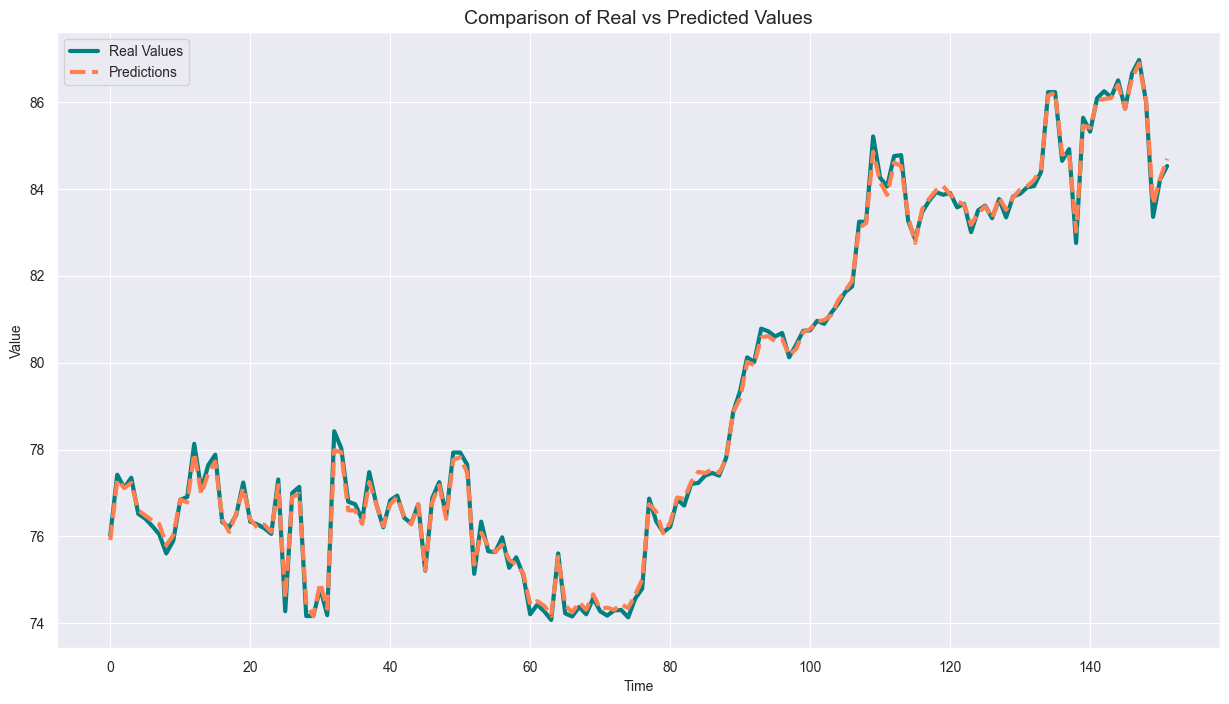

In [55]:
# Plot point forecast results
plt.figure(figsize=(15, 8))
plt.plot(Real_test, label='Real Values', color='teal', linestyle='solid')
plt.plot(Predictions_test, label='Predictions', color='coral', linestyle='dashed')
plt.title('Comparison of Real vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(loc='upper left')
plt.grid(True)
plt.savefig('Point_forecast_results.png')

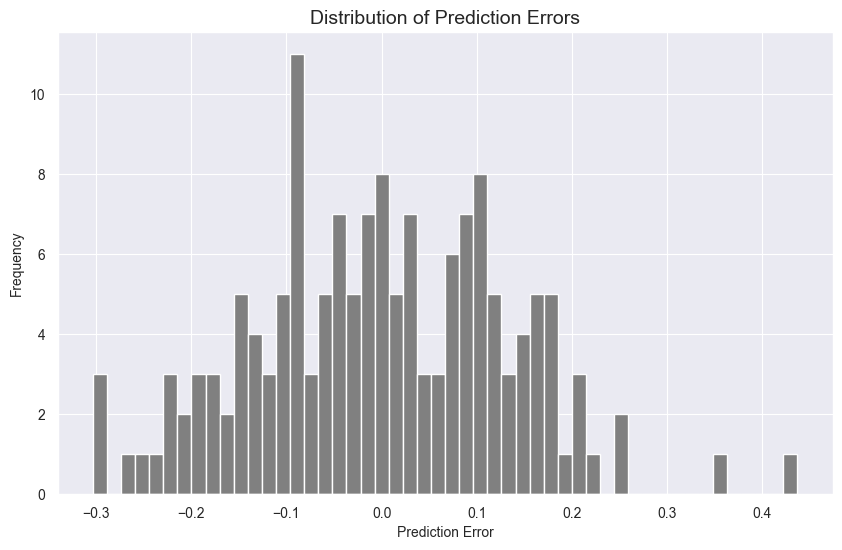

In [56]:
# Draw the error distribution
errors = Real_test - Predictions_test
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, color='gray')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()

# The process of interval prediction

In [57]:
y_cal_ture = sum_of_Valture
y_cal_predictions = Val_total_sum_of_predictions
y_val_ture = Real_test
y_val_predictions = Test_total_sum_of_predictions

In [58]:
# The q_yhat function
def calculate_q_yhat_naive(y_cal_ture,y_cal_predictions,alpha):
    N=len(y_cal_ture)
    q_yhat=np.quantile(np.abs(y_cal_ture-y_cal_predictions),np.ceil((N+1)*(1-alpha))/N)#
    return q_yhat

In [59]:
alpha=0.05
q_yhat=calculate_q_yhat_naive(y_cal_ture,y_cal_predictions,alpha)
q_yhat

0.4153902717929965

In [60]:
t1=y_val_predictions-q_yhat
print(t1)
print(t1.shape)
t2=y_val_predictions+q_yhat
print(t2)
print(t2.shape)
print(y_val_ture.shape)
N=len(y_val_ture)
print(y_val_ture[N-1])

[75.50218197 76.89431557 76.69826837 76.8167546  76.18755596 76.06933431
 75.94830084 75.86906496 75.38636109 75.61323606 76.4337573  76.36705131
 77.50221162 76.55747232 77.04405493 77.30797184 75.97618973 75.69034541
 76.11567892 76.70251702 75.98084627 75.78703954 75.85719503 75.6905247
 76.76335611 74.16804939 76.49443353 76.55878891 74.05509482 73.75041663
 74.51584873 73.92479072 77.56796174 77.5211698  76.18430711 76.1832824
 75.87332749 76.83567632 76.33627461 75.82198805 76.3239909  76.49467957
 76.03661558 75.86189861 76.32474222 74.80505971 76.37224296 76.75940343
 75.9918213  77.34723092 77.40794732 77.05160176 74.94110889 75.6703655
 75.36272257 75.22853421 75.39858963 75.04861198 74.94313168 74.74643694
 74.01490537 74.09607982 73.9913447  73.75966183 75.1170911  74.0018915
 73.83967711 74.06719809 73.89991973 74.25259895 73.92014656 73.94646887
 73.89739405 74.02651274 73.93795974 74.24043476 74.59513772 76.32558896
 76.15273979 75.65574282 75.90167775 76.48081273 76.448

In [61]:
def calculate_coverage(lower_bound,upper_bound,y_true):
    out_of_bound=0
    N=len(y_true)
    
    for i in range(N):
        if y_true[i]<lower_bound[i] or y_true[i]>upper_bound[i]:
            out_of_bound+=1
            
    return 1-out_of_bound/N

print('Coverage of {}'.format(calculate_coverage(y_val_predictions-q_yhat,y_val_predictions+q_yhat,y_val_ture)))#f_val+-q_yhat是预测的置信区间

Coverage of 0.993421052631579


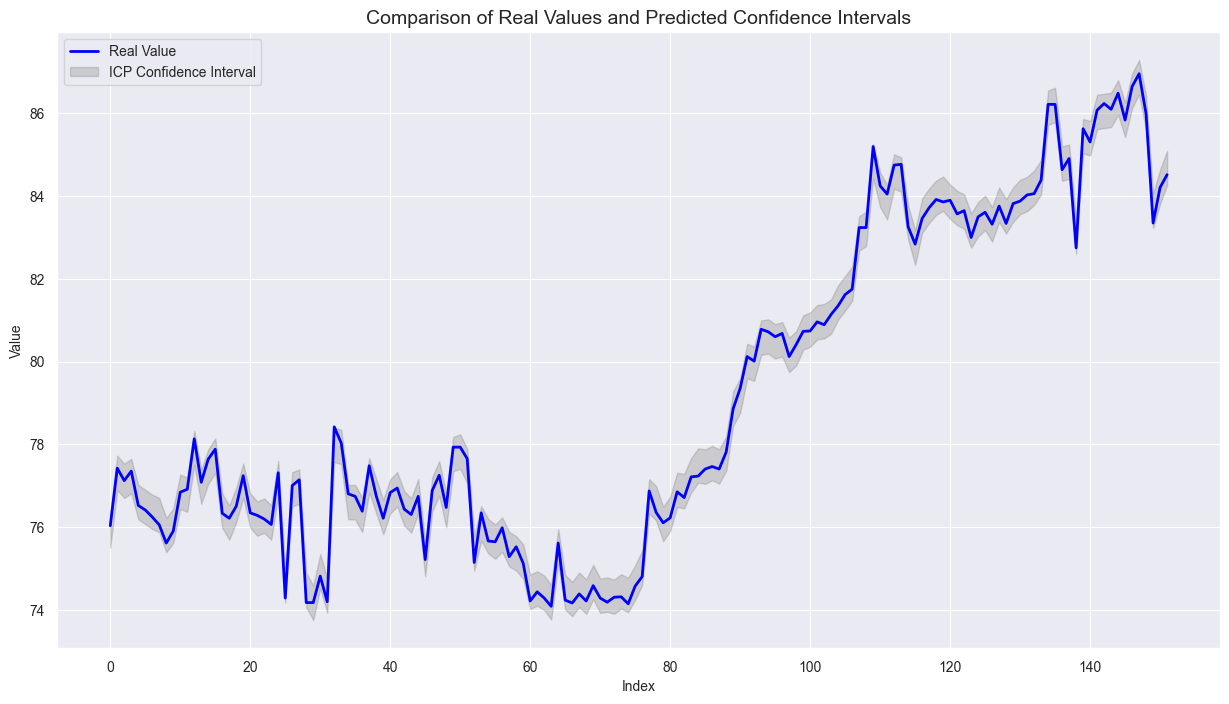

In [62]:
# Plot interval prediction results
plt.rcParams["figure.figsize"] = (15,8)
sns.set_style("darkgrid", {'axes.grid' : True})
ind=[i for i in range(len(y_val_ture))]
plt.plot(ind, y_val_ture, label='Real Value', color='blue', linewidth=2)
plt.fill_between(ind, y_val_predictions - q_yhat, y_val_predictions + q_yhat,
                 color='grey', alpha=0.3, label='ICP Confidence Interval')
plt.title('Comparison of Real Values and Predicted Confidence Intervals')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend(loc='upper left')
plt.savefig('Interval_prediction_results.png')

## Evaluation index calculation of interval prediction results

In [63]:
IP_y_pred = np.column_stack((t1, t2))
print(IP_y_pred)

[[75.50218197 76.33296252]
 [76.89431557 77.72509612]
 [76.69826837 77.52904891]
 [76.8167546  77.64753515]
 [76.18755596 77.01833651]
 [76.06933431 76.90011486]
 [75.94830084 76.77908139]
 [75.86906496 76.6998455 ]
 [75.38636109 76.21714163]
 [75.61323606 76.4440166 ]
 [76.4337573  77.26453785]
 [76.36705131 77.19783185]
 [77.50221162 78.33299216]
 [76.55747232 77.38825286]
 [77.04405493 77.87483547]
 [77.30797184 78.13875238]
 [75.97618973 76.80697028]
 [75.69034541 76.52112595]
 [76.11567892 76.94645946]
 [76.70251702 77.53329756]
 [75.98084627 76.81162681]
 [75.78703954 76.61782009]
 [75.85719503 76.68797557]
 [75.6905247  76.52130524]
 [76.76335611 77.59413665]
 [74.16804939 74.99882994]
 [76.49443353 77.32521408]
 [76.55878891 77.38956945]
 [74.05509482 74.88587536]
 [73.75041663 74.58119717]
 [74.51584873 75.34662927]
 [73.92479072 74.75557126]
 [77.56796174 78.39874228]
 [77.5211698  78.35195034]
 [76.18430711 77.01508765]
 [76.1832824  77.01406294]
 [75.87332749 76.70410803]
 

In [64]:
picp_target = 1-alpha
kappa = 10
def calculate_metrics(y_true, y_pred, picp_target, kappa):
    lower_bound = y_pred[:, 0]
    upper_bound = y_pred[:, 1]
    n_samples = len(y_true)
 
    # PICP
    in_interval = np.logical_and(y_true >= lower_bound, y_true <= upper_bound)
    PICP = np.sum(in_interval) / n_samples
 
    # PINAW
    interval_width = upper_bound - lower_bound
    normalized_width = np.mean(interval_width) / (np.max(y_true) - np.min(y_true))
    PINAW = normalized_width
    
    # CWC
    CWC = PINAW * (1 + np.exp(-kappa * (PICP - picp_target)))
 
    return PICP, PINAW, CWC

In [65]:
picp_target = 1-alpha
kappa = 10
PICP, PINAW, CWC = calculate_metrics(y_val_ture, IP_y_pred, picp_target, kappa)
print("PICP:", PICP)
print("PINAW:", PINAW)
print("CWC:", CWC)

PICP: 0.993421052631579
PINAW: 0.06450159497387369
CWC: 0.1062841715978832
